In [250]:
#install.packages("mice")
library(mice)    
library(ggplot2) 
#install.packages("patchwork")
library(patchwork)
#install.packages("ranger")
library(ranger)
#install.packages("transport")
library(transport)
library(ggplot2)
library(grid)  
library(gridExtra)
library(reshape2)
library(dplyr)
library(knitr)


In [251]:
# Functions for Imputation
# --- Function: Linear Regression Imputation ---
impute_lm <- function(data, missing_var, predictor_vars, m=5) {
  imp <- mice(data, method = "norm", m = m, maxit = 5, seed = 123, printFlag = FALSE)
  completed_data <- complete(imp)  # Get fully imputed dataset
  completed_datasets <- lapply(1:m, function(i) complete(imp, i))  # Return list of M imputations
  return(list(completed_data = completed_data, completed_datasets = completed_datasets))
}


# --- Function: PMM Imputation ---
impute_pmm <- function(data, missing_var, predictor_vars, m=5) {
  imp <- mice(data, method = "pmm", m = m, maxit = 5, seed = 123, printFlag = FALSE)
  completed_data <- complete(imp)
  completed_datasets <- lapply(1:m, function(i) complete(imp, i))  # Return list of M imputations
  return(list(completed_data = completed_data, completed_datasets = completed_datasets))
}


# --- Function: boot Linear Regression Imputation ---
impute_boot <- function(data, missing_var, predictor_vars, m=5) {
  imp <- mice(data, method = "norm.boot", m = m, maxit = 5, seed = 123, printFlag = FALSE)
  completed_data <- complete(imp)  # Get fully imputed dataset
  completed_datasets <- lapply(1:m, function(i) complete(imp, i))  # Return list of M imputations
  return(list(completed_data = completed_data, completed_datasets = completed_datasets))
}


# --- Function: Random Forest Imputation ---
impute_rf <- function(data, missing_var, predictor_vars, m=5) {
  imp <- mice(data, method = "rf", m = m, maxit = 5, seed = 123, printFlag = FALSE)
  completed_data <- complete(imp)  # Get fully imputed dataset
  completed_datasets <- lapply(1:m, function(i) complete(imp, i))  # Return list of M imputations
  return(list(completed_data = completed_data, completed_datasets = completed_datasets))
}


In [252]:
# Functions for Evaluation
# --- Function: Within_Imputation_Var = U_bar, Between_Imputation_Var = B_M calculation ---
compute_variance <- function(imputed_datasets, variable = "y") {
  M <- length(imputed_datasets)  # Number of imputed datasets
  # Compute mean imputed value across M datasets
  Q_m <- sapply(imputed_datasets, function(df) mean(df[[variable]], na.rm = TRUE))
  
  # Compute within-imputation variance (U_bar)
  U_m <- sapply(imputed_datasets, function(df) var(df[[variable]], na.rm = TRUE))
  U_bar <- mean(U_m)

  # Compute between-imputation variance (B_M)
  Q_bar <- mean(Q_m)
  B_M <- sum((Q_m - Q_bar)^2) / (M - 1)

  # Compute total variance (T_M)
  T_M <- U_bar + (1 + (1 / M)) * B_M

  return(list(Ubar = U_bar, Bm = B_M, Tm = T_M))
}

eval_continuous <- function(imputed_datasets, df_original, missing_indices) {
  M <- length(imputed_datasets)
  imputed_values_matrix <- do.call(cbind, lapply(imputed_datasets, function(df) df$y[missing_indices]))
  mean_imputed_values <- rowMeans(imputed_values_matrix, na.rm = TRUE)

  # RMSE
  rmse_value <- sqrt(mean((mean_imputed_values - df_original$y[missing_indices])^2))

  # MAE
  mae_value <- mean(abs(mean_imputed_values - df_original$y[missing_indices]))

  # Wasserstein Distance
  wasserstein_value <- wasserstein1d(mean_imputed_values, df_original$y[missing_indices])

  # Return all three metrics as a list
  return(list(rmse = rmse_value, mae = mae_value, wasserstein = wasserstein_value))
}


# --- Function: Create Scatter Plots ---
scatter_plot <- function(original_df, df1, df2, df3, df4, missing_indices, title, subtitle) {
  original_missing <- original_df[missing_indices, ]  # Filter only missing values

  ggplot(original_missing, aes_string(x="x", y="y")) +
    geom_point(alpha = 0.5, color = "black") +  # True missing values

    geom_point(data = df1[missing_indices, ], aes_string(x="x", y="y"), color = "green", alpha = 0.5) +
    geom_smooth(data = df1, aes_string(x="x", y="y"), color = "green", method = "lm", se = TRUE) +
    
    geom_point(data = df2[missing_indices, ], aes_string(x="x", y="y"), color = "blue", alpha = 0.3) +
    geom_smooth(data = df2, aes_string(x="x", y="y"), color = "blue", method = "lm", se = TRUE) +

    geom_point(data = df3[missing_indices, ], aes_string(x="x", y="y"), color = "red", alpha = 0.3) +
    geom_smooth(data = df3, aes_string(x="x", y="y"), color = "red", method = "loess", se = TRUE) +

    geom_point(data = df4[missing_indices, ], aes_string(x="x", y="y"), color = "purple", alpha = 0.3) +
    geom_smooth(data = df4, aes_string(x="x", y="y"), color = "purple", method = "loess", se = TRUE) +

    labs(title = title, subtitle = subtitle)
}

# --- Function: Create Density Plots ---
density_plot <- function(original_df, df1, df2, df3, df4, missing_indices, title, subtitle) {
  original_missing <- original_df[missing_indices, ]  # Select only missing parts
  df1_missing <- df1[missing_indices, ]
  df2_missing <- df2[missing_indices, ]
  df3_missing <- df3[missing_indices, ]
  df4_missing <- df4[missing_indices, ]
  
  ggplot() +
    geom_density(data = original_missing, aes_string(x = "y"), color = "black", lwd = 1) +  # True missing values
    geom_density(data = df1_missing, aes_string(x = "y"), color = "green", lwd = 0.5, alpha = 0.3) +  # Imputed LM
    geom_density(data = df2_missing, aes_string(x = "y"), color = "blue", lwd = 0.5, alpha = 0.3) +  # Imputed PMM
    geom_density(data = df3_missing, aes_string(x = "y"), color = "red", lwd = 0.5, alpha = 0.3) +  # Imputed boot
    geom_density(data = df4_missing, aes_string(x = "y"), color = "purple", lwd = 0.5, alpha = 0.3) +  # Imputed RF
    labs(title = title, subtitle = subtitle) +
    theme_minimal()
}





In [265]:
# Functions for Data Generation
generate_linear_data <- function(n, p, random_seed) {
    set.seed(random_seed)  
    x <- runif(n, 0, 20)
    y <- -2 + 0.5*x + rnorm(n, 0, 0.5)  
    #y <- pmin(pmax(y, 0), 10)  
    df_original <- data.frame(x, y)
    df_wmar <- df_original
    df_mar <- df_original
    
    
    # Normalize x to [0, 1] range
    x_scaled <- (x - min(x)) / (max(x) - min(x))

    # Generate missingness scores with some random noise
    score_wmar <- 0.3 + 0.3 * x_scaled + runif(n, 0, 0.5) 
    score_mar  <- 0.1 + 0.8 * x_scaled^3 + runif(n, 0, 0.5)

    # Rank and select top p*n for missing values
    num_missing <- floor(n * p)
    missing_indices_wmar <- order(score_wmar, decreasing = TRUE)[1:num_missing]
    missing_indices_mar  <- order(score_mar,  decreasing = TRUE)[1:num_missing]

    # Weak MAR: Weak missingness dependent on x 
    df_wmar$y[missing_indices_wmar] <- NA  
    
    # MAR: Strong Missingness dependent on x
    df_mar$y[missing_indices_mar] <- NA  

    return(list(original = df_original, wmar = df_wmar, mar = df_mar, missing_indices_wmar = missing_indices_wmar, missing_indices_mar = missing_indices_mar))
}

generate_poly_data <- function(n, p, random_seed) {
    set.seed(random_seed)  
    x <- runif(n, 0, 20)
    y <- -0.5*x + 0.2*x^2 + 0.005*x^3 - 0.002*x^4 + rnorm(n, 0, 0.5)   
    #y <- pmin(pmax(y, 0), 10)  # Ensure y is in [0,10]
    df_original <- data.frame(x, y)
    df_wmar <- df_original
    df_mar <- df_original
    
    # Normalize x to [0, 1] range
    x_scaled <- (x - min(x)) / (max(x) - min(x))

    # Generate missingness scores with some random noise
    score_wmar <- 0.3 + 0.3 * x_scaled + runif(n, 0, 0.5) 
    score_mar  <- 0.1 + 0.8 * x_scaled^3 + runif(n, 0, 0.5)

    # Rank and select top p*n for missing values
    num_missing <- floor(n * p)
    missing_indices_wmar <- order(score_wmar, decreasing = TRUE)[1:num_missing]
    missing_indices_mar  <- order(score_mar,  decreasing = TRUE)[1:num_missing]

    # Weak MAR: Weak missingness dependent on x 
    df_wmar$y[missing_indices_wmar] <- NA  
    
    # MAR: Strong Missingness dependent on x
    df_mar$y[missing_indices_mar] <- NA  
    
    return(list(original = df_original, wmar = df_wmar, mar = df_mar, missing_indices_wmar = missing_indices_wmar, missing_indices_mar = missing_indices_mar))
}

# generate_nonlinear_data <- function(n, p, random_seed) {
#     set.seed(random_seed)  
#     x <- runif(n, 0, 20)
#     y <- sin(x) * exp(-0.1*x) + rnorm(n, 0, 0.5)   
#     #y <- pmin(pmax(y, 0), 10)  # Ensure y is in [0,10] 
#     df_original <- data.frame(x, y)
#     df_wmar <- df_original
#     df_mar <- df_original

#     # Normalize x to [0, 1] range
#     x_scaled <- (x - min(x)) / (max(x) - min(x))

#     # Generate missingness scores with some random noise
#     score_wmar <- 0.3 + 0.3 * x_scaled + runif(n, 0, 0.1) 
#     score_mar  <- 0.05 + 0.9 * x_scaled^3 + runif(n, 0, 0.1)

#     # Rank and select top p*n for missing values
#     num_missing <- floor(n * p)
#     missing_indices_wmar <- order(score_wmar, decreasing = TRUE)[1:num_missing]
#     missing_indices_mar  <- order(score_mar,  decreasing = TRUE)[1:num_missing]

#     # Weak MAR: Weak missingness dependent on x 
#     df_wmar$y[missing_indices_wmar] <- NA  
    
#     # MAR: Strong Missingness dependent on x
#     df_mar$y[missing_indices_mar] <- NA  
    
#     return(list(original = df_original, wmar = df_wmar, mar = df_mar, missing_indices_wmar = missing_indices_wmar, missing_indices_mar = missing_indices_mar))
# }



In [273]:
#### Example for continuous missing variable y, when n = 200, p = 0.25
n <- 200
p <- 0.25
seed <- 123

# --- Step 1.1: Generate Data (Linear Relationship) ---
df1 <- generate_linear_data(n, p, seed)
df1_original <- df1$original
df1_wmar <- df1$wmar
df1_mar <- df1$mar
missing_indices_wmar_1 = df1$missing_indices_wmar
missing_indices_mar_1 = df1$missing_indices_mar

# --- Step 1.2: Generate Data (Polynomial Relationship) ---
df2 <- generate_poly_data(n, p, seed)
df2_original <- df2$original
df2_wmar <- df2$wmar
df2_mar <- df2$mar
missing_indices_wmar_2 = df2$missing_indices_wmar
missing_indices_mar_2 = df2$missing_indices_mar


# # --- Step 1.3: Generate Data (Nonlinear Relationship) ---
# df3 <- generate_nonlinear_data(n, p, seed)
# df3_original <- df3$original
# df3_wmar <- df3$wmar
# df3_mar <- df3$mar
# missing_indices_wmar_3 = df3$missing_indices_wmar
# missing_indices_mar_3 = df3$missing_indices_mar

# --- Step 2: Impute Missing Data ---
# Define data types and imputation methods
data_types <- c("df1", "df2")  # Corresponds to linear, polynomial
imputation_methods <- list(lm = impute_lm, pmm = impute_pmm, boot = impute_boot, rf = impute_rf)
missing_types <- c("wmar", "mar")

# Loop through data types, missing types, and imputation methods
for (data_type in data_types) {
  for (missing_type in missing_types) {
    for (method_name in names(imputation_methods)) {

      # Select imputation method
      impute_function <- imputation_methods[[method_name]]
      
      # Get the corresponding missing dataset
      missing_data_name <- paste0(data_type, "_", missing_type)  # Example: "df1_wmar"
      df_missing <- get(missing_data_name)  # Get the actual dataset object
      
      # Perform imputation
      imputed_list <- impute_function(df_missing, "y", "x")
      
      # Generate variable names dynamically
      completed_name <- paste0(data_type, "_", method_name, "_", missing_type)
      
      # Assign variables dynamically
      assign(completed_name, imputed_list$completed_datasets)
    }
  }
}

# an example of the imputed dataset name is: df1_lm_wmar
# reference to the second imputed datasets of missing values: df1_lm_wmar[[1]]$y[missing_indices_wmar_1]

# --- Step 3: Compare Performance ---
# Loop through data types, missing types, and imputation methods
for (data_type in data_types) {
  for (missing_type in missing_types) {
    for (method_name in names(imputation_methods)) {

      # Construct variable names
      imputed_var_name <- paste0(data_type, "_", method_name, "_", missing_type)
      original_var_name <- paste0(data_type, "_original")
      missing_indices_var_name <- paste0("missing_indices_", missing_type, "_", substr(data_type, 3, 3))

      # Get imputed dataset, original data, and missing indices
      imputed_data <- get(imputed_var_name)
      original_data <- get(original_var_name)
      missing_indices <- get(missing_indices_var_name)

      # Compute evaluation metrics
      eval_metrics <- eval_continuous(imputed_data, original_data, missing_indices)
      var_metrics <- compute_variance(imputed_data)

      # Generate dynamic variable names for RMSE, MAE, Wasserstein
      rmse_name <- paste0("rmse_", imputed_var_name)
      mae_name <- paste0("mae_", imputed_var_name)
      wasserstein_name <- paste0("wasserstein_", imputed_var_name)
      Bm_name <- paste0("Bm_", imputed_var_name)
      Tm_name <- paste0("Tm_", imputed_var_name)
      Ubar_name <- paste0("Ubar_", imputed_var_name)

      imputed_means <- sapply(imputed_data, function(df) mean(df$y, na.rm = TRUE))
      true_mean <- mean(original_data$y, na.rm = TRUE)
      estimate_rmse <- sqrt(mean((imputed_means - true_mean)^2))
      estimate_mae <- mean(abs(imputed_means - true_mean))

      # Compute adjusted Ubar (should approximate Tm)
      #sigma2_obs <- var(original_data$y[-missing_indices], na.rm = TRUE)
      #sigma2 <- var(original_data$y, na.rm = TRUE)
      #adjusted_Ubar <- var_metrics$Ubar * (sigma2_obs / sigma2) * (1 / (1 - p))



      # Assign values dynamically
      assign(rmse_name, eval_metrics$rmse)
      assign(mae_name, eval_metrics$mae)
      assign(wasserstein_name, eval_metrics$wasserstein)
      assign(Bm_name, var_metrics$Bm)
      assign(Tm_name, var_metrics$Tm)
      assign(Ubar_name, var_metrics$Ubar)
      assign(paste0("estimate_rmse_", imputed_var_name), estimate_rmse)
      assign(paste0("estimate_mae_", imputed_var_name), estimate_mae)
      #assign(paste0("adjusted_Ubar_", imputed_var_name), adjusted_Ubar)
    }
  }
}

# Examples:
# rmse_df1_lm_wmar  RMSE for df1, lm, wmar
# mae_df2_pmm_mar   MAE for df2, pmm, MAR
# wasserstein_df3_lm_wmar  Wasserstein distance for df3, lm, wmar
# Bm_df1_lm_wmar   B_M for df1, lm, wmar
# Tm_df2_pmm_mar   T_M for df2, pmm, MAR
# Ubar_df3_lm_wmar  U_bar for df3, lm, wmar



# --- Step 4: Result Presentation ---
results_linear <- list()
results_poly <- list()

# Loop through all imputation combinations
for (data_type in data_types) {
  method_results <- list()  # Store metrics for each method in columns
  
  for (missing_type in missing_types) {
    for (method_name in names(imputation_methods)) {

      # Construct variable names dynamically
      imputed_var_name <- paste0(data_type, "_", method_name, "_", missing_type)
      col_name <- paste(method_name, missing_type, sep = "_")  # Column name

      # Fetch metric values
      rmse_val <- get(paste0("rmse_", imputed_var_name))
      mae_val <- get(paste0("mae_", imputed_var_name))
      wasserstein_val <- get(paste0("wasserstein_", imputed_var_name))
      Ubar_val <- get(paste0("Ubar_", imputed_var_name))
      Bm_val <- get(paste0("Bm_", imputed_var_name))
      Tm_val <- get(paste0("Tm_", imputed_var_name))
      estimate_rmse_val <- get(paste0("estimate_rmse_", imputed_var_name))
      estimate_mae_val <- get(paste0("estimate_mae_", imputed_var_name))
      #adjusted_Ubar_val <- get(paste0("adjusted_Ubar_", imputed_var_name))

      # Store metrics in a list under the column name
      method_results[[col_name]] <- c(rmse_val, mae_val, wasserstein_val, Ubar_val, Bm_val, Tm_val,  #adjusted_Ubar_val,
                                      estimate_rmse_val, estimate_mae_val)
    }
  }

  # Create a data frame where metric names are rows and methods are columns
  df_results <- as.data.frame(method_results, row.names = c("RMSE", "MAE", "Wasserstein", "Ubar", "Bm", "Tm", "Est_RMSE", "Est_MAE"))


  # Assign to the correct dataset type
  if (data_type == "df1") {
    df_results_linear <- df_results
  } else if (data_type == "df2") {
    df_results_poly <- df_results
  } #else if (data_type == "df3") {
    #df_results_nonlinear <- df_results
  #}
}

# Print to verify
kable(df_results_linear, caption = "Imputation Performance (Linear Data)")
kable(df_results_poly, caption = "Imputation Performance (Polynomial Data)")


#### Example Plots
# --- Create Plots for Linear Data ---
linear_wmar_scatter1 <- scatter_plot(df1_original, df1_lm_wmar[[1]], df1_pmm_wmar[[1]], df1_boot_wmar[[1]], df1_rf_wmar[[1]], missing_indices_wmar_1, "Linear Data (Weak MAR) n=200 p=0.25", "Black = True, Green = LM, Red = LM-boostrap, Blue = PMM, Purple = RF")
linear_wmar_scatter2 <- scatter_plot(df1_original, df1_lm_wmar[[2]], df1_pmm_wmar[[2]], df1_boot_wmar[[2]], df1_rf_wmar[[2]], missing_indices_wmar_1, "", "")
linear_wmar_scatter3 <- scatter_plot(df1_original, df1_lm_wmar[[3]], df1_pmm_wmar[[3]], df1_boot_wmar[[3]], df1_rf_wmar[[3]], missing_indices_wmar_1, "", "")
linear_wmar_density1 <- density_plot(df1_original, df1_lm_wmar[[1]], df1_pmm_wmar[[1]], df1_boot_wmar[[1]], df1_rf_wmar[[1]], missing_indices_wmar_1, "", "")
linear_wmar_density2 <- density_plot(df1_original, df1_lm_wmar[[2]], df1_pmm_wmar[[2]], df1_boot_wmar[[2]], df1_rf_wmar[[2]], missing_indices_wmar_1, "", "")
linear_wmar_density3 <- density_plot(df1_original, df1_lm_wmar[[3]], df1_pmm_wmar[[3]], df1_boot_wmar[[3]], df1_rf_wmar[[3]], missing_indices_wmar_1, "", "")

linear_mar_scatter1 <- scatter_plot(df1_original, df1_lm_mar[[1]], df1_pmm_mar[[1]], df1_boot_mar[[1]], df1_rf_mar[[1]], missing_indices_mar_1, "Linear Data (Strong MAR) n=200 p=0.25", "Black = True, Green = LM, Red = LM-boostrap, Blue = PMM, Purple = RF")
linear_mar_scatter2 <- scatter_plot(df1_original, df1_lm_mar[[2]], df1_pmm_mar[[2]], df1_boot_mar[[2]], df1_rf_mar[[2]], missing_indices_mar_1, "", "")
linear_mar_scatter3 <- scatter_plot(df1_original, df1_lm_mar[[3]], df1_pmm_mar[[3]], df1_boot_mar[[3]], df1_rf_mar[[3]], missing_indices_mar_1, "", "")
linear_mar_density1 <- density_plot(df1_original, df1_lm_mar[[1]], df1_pmm_mar[[1]], df1_boot_mar[[1]], df1_rf_mar[[1]], missing_indices_mar_1, "", "")
linear_mar_density2 <- density_plot(df1_original, df1_lm_mar[[2]], df1_pmm_mar[[2]], df1_boot_mar[[2]], df1_rf_mar[[2]], missing_indices_mar_1, "", "")
linear_mar_density3 <- density_plot(df1_original, df1_lm_mar[[3]], df1_pmm_mar[[3]], df1_boot_mar[[3]], df1_rf_mar[[3]], missing_indices_mar_1, "", "")

# --- Create Plots for Polynomial Data ---
poly_wmar_scatter1 <- scatter_plot(df2_original, df2_lm_wmar[[1]], df2_pmm_wmar[[1]], df2_boot_wmar[[1]], df2_rf_wmar[[1]], missing_indices_wmar_2, "Polynomial Data (Weak MAR) n=200 p=0.25", "Black = True, Green = LM, Red = LM-boostrap, Blue = PMM, Purple = RF")
poly_wmar_scatter2 <- scatter_plot(df2_original, df2_lm_wmar[[2]], df2_pmm_wmar[[2]], df2_boot_wmar[[2]], df2_rf_wmar[[2]], missing_indices_wmar_2, "", "")
poly_wmar_scatter3 <- scatter_plot(df2_original, df2_lm_wmar[[3]], df2_pmm_wmar[[3]], df2_boot_wmar[[3]], df2_rf_wmar[[3]], missing_indices_wmar_2, "", "")
poly_wmar_density1 <- density_plot(df2_original, df2_lm_wmar[[1]], df2_pmm_wmar[[1]], df2_boot_wmar[[1]], df2_rf_wmar[[1]], missing_indices_wmar_2, "", "")
poly_wmar_density2 <- density_plot(df2_original, df2_lm_wmar[[2]], df2_pmm_wmar[[2]], df2_boot_wmar[[2]], df2_rf_wmar[[2]], missing_indices_wmar_2, "", "")
poly_wmar_density3 <- density_plot(df2_original, df2_lm_wmar[[3]], df2_pmm_wmar[[3]], df2_boot_wmar[[3]], df2_rf_wmar[[3]], missing_indices_wmar_2, "", "")

poly_mar_scatter1 <- scatter_plot(df2_original, df2_lm_mar[[1]], df2_pmm_mar[[1]], df2_boot_mar[[1]], df2_rf_mar[[1]], missing_indices_mar_2, "Polynomial Data (Strong MAR) n=200 p=0.25", "Black = True, Green = LM, Red = LM-boostrap, Blue = PMM, Purple = RF")
poly_mar_scatter2 <- scatter_plot(df2_original, df2_lm_mar[[2]], df2_pmm_mar[[2]], df2_boot_mar[[2]], df2_rf_mar[[2]], missing_indices_mar_2, "", "")
poly_mar_scatter3 <- scatter_plot(df2_original, df2_lm_mar[[3]], df2_pmm_mar[[3]], df2_boot_mar[[3]], df2_rf_mar[[3]], missing_indices_mar_2, "", "")
poly_mar_density1 <- density_plot(df2_original, df2_lm_mar[[1]], df2_pmm_mar[[1]], df2_boot_mar[[1]], df2_rf_mar[[1]], missing_indices_mar_2, "", "")
poly_mar_density2 <- density_plot(df2_original, df2_lm_mar[[2]], df2_pmm_mar[[2]], df2_boot_mar[[2]], df2_rf_mar[[2]], missing_indices_mar_2, "", "")
poly_mar_density3 <- density_plot(df2_original, df2_lm_mar[[3]], df2_pmm_mar[[3]], df2_boot_mar[[3]], df2_rf_mar[[3]], missing_indices_mar_2, "", "")

# # --- Create Plots for Nonlinear Data ---

# nonlinear_wmar_scatter1 <- scatter_plot(df3_original, df3_lm_wmar[[1]], df3_pmm_wmar[[1]], df3_boot_wmar[[1]], df3_rf_wmar[[1]], missing_indices_wmar_3, "Nonlinear Data (wmar) n=200 p=0.25", "Black = True, Green = LM, Red = LM-boostrap, Blue = PMM, Purple = RF")
# nonlinear_wmar_scatter2 <- scatter_plot(df3_original, df3_lm_wmar[[2]], df3_pmm_wmar[[2]], df3_boot_wmar[[2]], df3_rf_wmar[[2]], missing_indices_wmar_3, "", "")
# nonlinear_wmar_scatter3 <- scatter_plot(df3_original, df3_lm_wmar[[3]], df3_pmm_wmar[[3]], df3_boot_wmar[[3]], df3_rf_wmar[[3]], missing_indices_wmar_3, "", "")
# nonlinear_wmar_density1 <- density_plot(df3_original, df3_lm_wmar[[1]], df3_pmm_wmar[[1]], df3_boot_wmar[[1]], df3_rf_wmar[[1]], missing_indices_wmar_3, "", "")
# nonlinear_wmar_density2 <- density_plot(df3_original, df3_lm_wmar[[2]], df3_pmm_wmar[[2]], df3_boot_wmar[[2]], df3_rf_wmar[[2]], missing_indices_wmar_3, "", "")
# nonlinear_wmar_density3 <- density_plot(df3_original, df3_lm_wmar[[3]], df3_pmm_wmar[[3]], df3_boot_wmar[[3]], df3_rf_wmar[[3]], missing_indices_wmar_3, "", "")

# nonlinear_mar_scatter1 <- scatter_plot(df3_original, df3_lm_mar[[1]], df3_pmm_mar[[1]], df3_boot_mar[[1]], df3_rf_mar[[1]], missing_indices_mar_3, "Nonlinear Data (MAR) n=200 p=0.25", "Black = True, Green = LM, Red = LM-boostrap, Blue = PMM, Purple = RF")
# nonlinear_mar_scatter2 <- scatter_plot(df3_original, df3_lm_mar[[2]], df3_pmm_mar[[2]], df3_boot_mar[[2]], df3_rf_mar[[2]], missing_indices_mar_3, "", "")
# nonlinear_mar_scatter3 <- scatter_plot(df3_original, df3_lm_mar[[3]], df3_pmm_mar[[3]], df3_boot_mar[[3]], df3_rf_mar[[3]], missing_indices_mar_3, "", "")
# nonlinear_mar_density1 <- density_plot(df3_original, df3_lm_mar[[1]], df3_pmm_mar[[1]], df3_boot_mar[[1]], df3_rf_mar[[1]], missing_indices_mar_3, "", "")
# nonlinear_mar_density2 <- density_plot(df3_original, df3_lm_mar[[2]], df3_pmm_mar[[2]], df3_boot_mar[[2]], df3_rf_mar[[2]], missing_indices_mar_3, "", "")
# nonlinear_mar_density3 <- density_plot(df3_original, df3_lm_mar[[3]], df3_pmm_mar[[3]], df3_boot_mar[[3]], df3_rf_mar[[3]], missing_indices_mar_3, "", "")






Table: Imputation Performance (Linear Data)

|            |   lm_wmar|  pmm_wmar| boot_wmar|   rf_wmar|    lm_mar|   pmm_mar|  boot_mar|    rf_mar|
|:-----------|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|
|RMSE        | 0.4458432| 0.5238725| 0.5097125| 0.6000940| 0.5041566| 0.9840368| 0.4560012| 0.9552844|
|MAE         | 0.3690497| 0.4168679| 0.3944741| 0.4573688| 0.3863894| 0.7764971| 0.3409408| 0.7461316|
|Wasserstein | 0.1647906| 0.2438919| 0.2121318| 0.2395749| 0.2001646| 0.6784232| 0.1979156| 0.6473970|
|Ubar        | 7.4919805| 7.4474557| 7.4047752| 7.4705182| 7.3827484| 6.4217647| 7.3814568| 6.4634871|
|Bm          | 0.0008269| 0.0002255| 0.0010204| 0.0000793| 0.0014060| 0.0002234| 0.0007839| 0.0000658|
|Tm          | 7.4929727| 7.4477263| 7.4059997| 7.4706135| 7.3844356| 6.4220328| 7.3823975| 6.4635660|
|Est_RMSE    | 0.0359773| 0.0172642| 0.0413762| 0.0102865| 0.0537016| 0.1630903| 0.0496265| 0.1534031|
|Est_MAE     | 0.0261304| 



Table: Imputation Performance (Polynomial Data)

|            |     lm_wmar|    pmm_wmar|   boot_wmar|      rf_wmar|     lm_mar|     pmm_mar|   boot_mar|       rf_mar|
|:-----------|-----------:|-----------:|-----------:|------------:|----------:|-----------:|----------:|------------:|
|RMSE        |   45.089695|    6.454054|   41.811215|    8.9453445|  82.451602|   50.549810|  82.436618|   48.2373717|
|MAE         |   35.286760|    4.104010|   33.802637|    5.4502518|  67.348909|   35.531310|  66.586935|   32.0112118|
|Wasserstein |   32.291435|    3.126934|   30.928611|    3.5815406|  65.438768|   35.496982|  65.564414|   31.4846640|
|Ubar        | 2090.666790| 2787.071404| 2082.552463| 2957.5756861| 562.776732| 1215.112878| 562.445194| 1348.8876705|
|Bm          |    2.758276|   10.517523|    3.083795|    0.1082079|   1.229505|    1.666280|   2.433328|    0.8305714|
|Tm          | 2093.976722| 2799.692432| 2086.253017| 2957.7055356| 564.252139| 1217.112414| 565.365187| 1349.884356

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


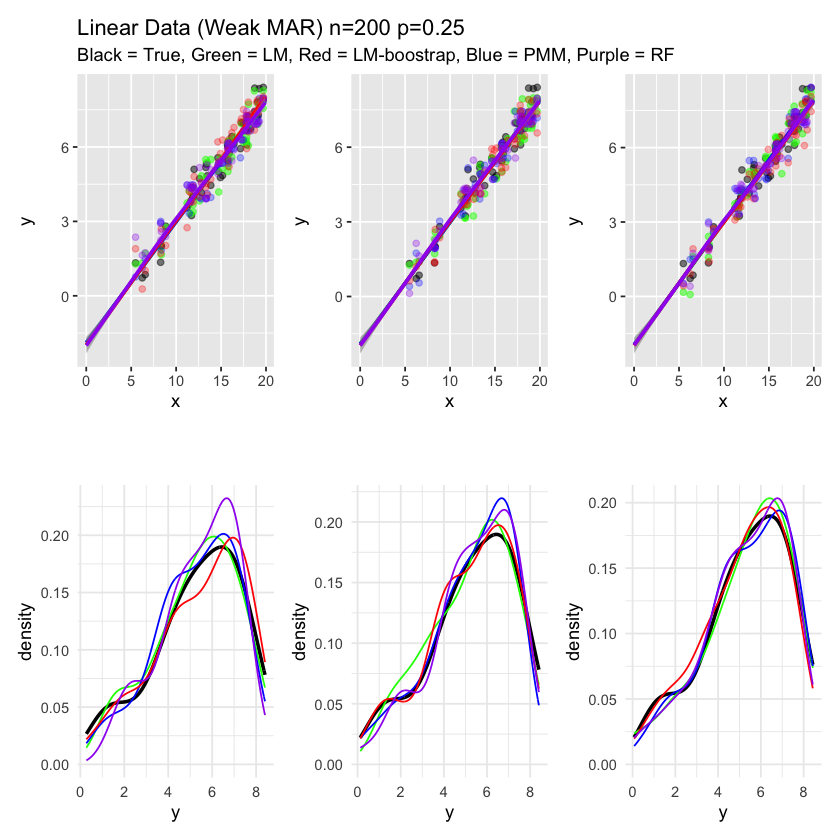

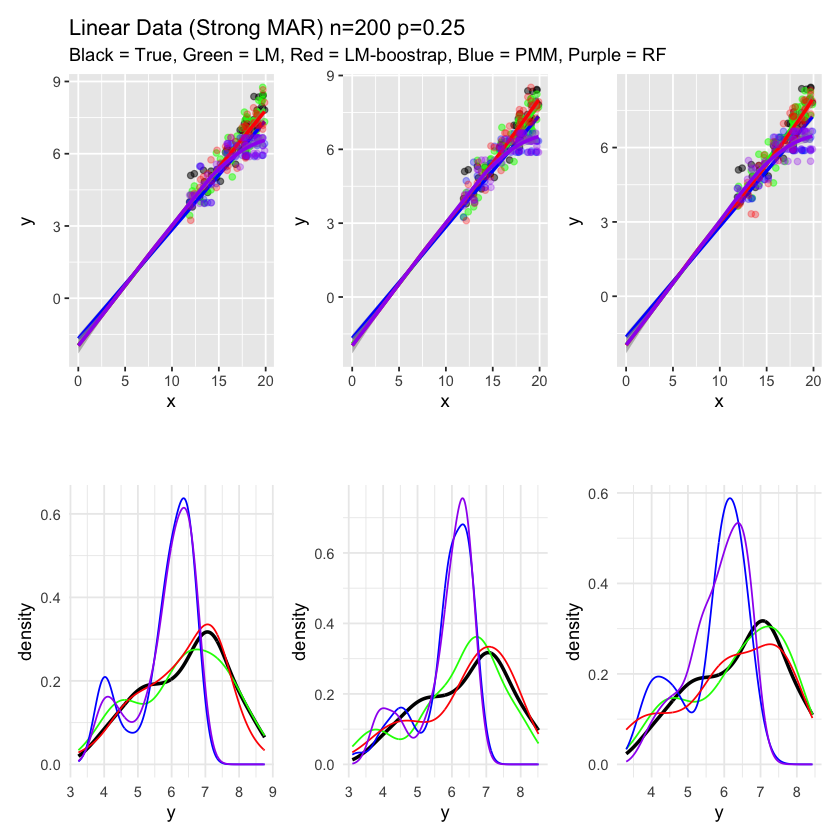

In [274]:
# --- Display Linear Data ---
linear_wmar_scatter1 + linear_wmar_scatter2 + linear_wmar_scatter3 +
linear_wmar_density1 + linear_wmar_density2 + linear_wmar_density3 +
plot_layout(nrow = 2)

linear_mar_scatter1 + linear_mar_scatter2 + linear_mar_scatter3 +
linear_mar_density1 + linear_mar_density2 + linear_mar_density3 +
plot_layout(nrow = 2)



`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


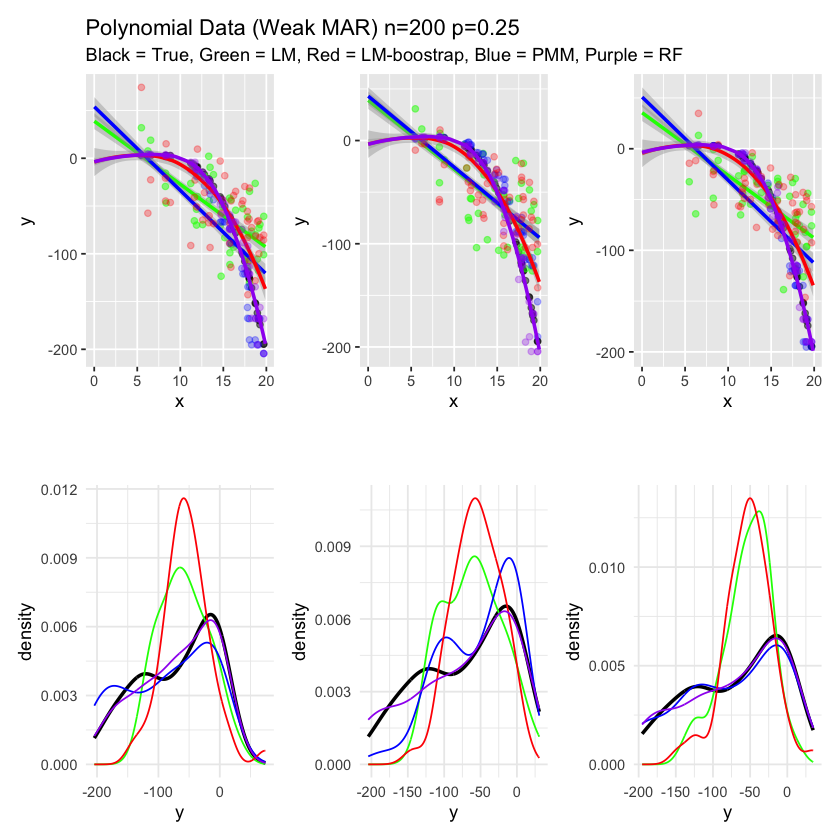

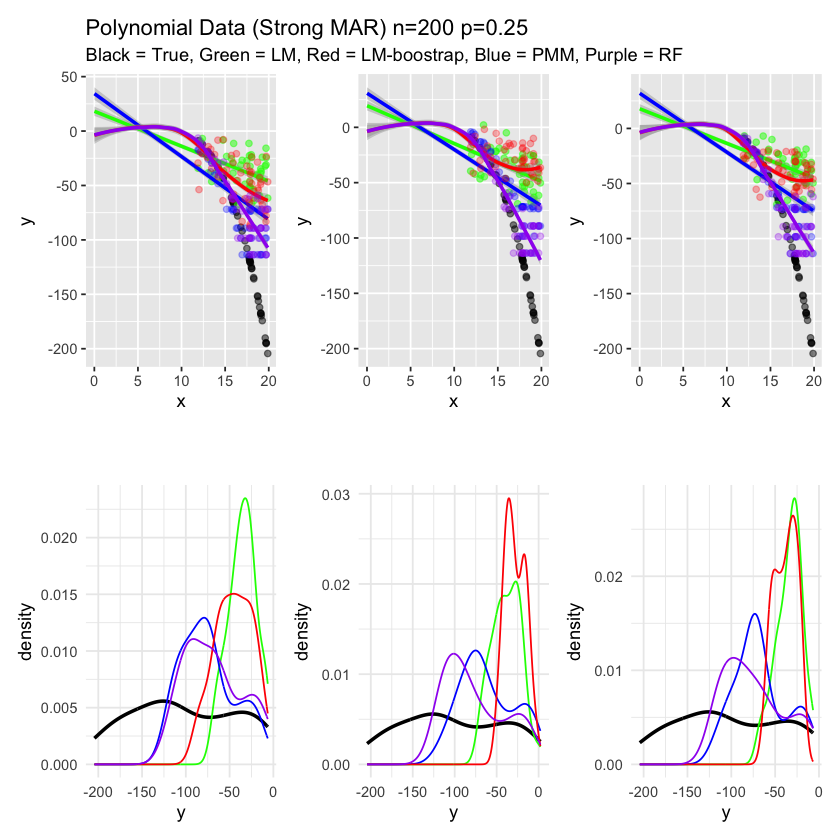

In [275]:
# --- Display Poly Data ---
poly_wmar_scatter1 + poly_wmar_scatter2 + poly_wmar_scatter3 + 
poly_wmar_density1 + poly_wmar_density2 + poly_wmar_density3 +
plot_layout(nrow = 2)


poly_mar_scatter1 + poly_mar_scatter2 + poly_mar_scatter3 +
poly_mar_density1 + poly_mar_density2 + poly_mar_density3 +
plot_layout(nrow = 2)

In [272]:
# # --- Display Nonlinear Data ---
# nonlinear_wmar_scatter1 + nonlinear_wmar_scatter2 + nonlinear_wmar_scatter3 + 
# nonlinear_wmar_density1 + nonlinear_wmar_density2 + nonlinear_wmar_density3 +
# plot_layout(nrow = 2)


# nonlinear_mar_scatter1 + nonlinear_mar_scatter2 + nonlinear_mar_scatter3 +
# nonlinear_mar_density1 + nonlinear_mar_density2 + nonlinear_mar_density3 +
# plot_layout(nrow = 2)

In [276]:
#### Continuou y: loop through different proportions of missing values
p_values <- (1:12)/20 # Example missing proportions
n <- 500  # Sample size
seed <- 548  # Fixed seed for reproducibility


results_linear <- data.frame(
  missing_proportion = numeric(),  # Missing proportion
  rmse_lm_wmar = numeric(), rmse_pmm_wmar = numeric(), rmse_boot_wmar = numeric(), rmse_rf_wmar = numeric(),
  mae_lm_wmar = numeric(), mae_pmm_wmar = numeric(), mae_boot_wmar = numeric(), mae_rf_wmar = numeric(),
  wasserstein_lm_wmar = numeric(), wasserstein_pmm_wmar = numeric(), wasserstein_boot_wmar = numeric(), wasserstein_rf_wmar = numeric(),
  Ubar_lm_wmar = numeric(), Ubar_pmm_wmar = numeric(), Ubar_boot_wmar = numeric(), Ubar_rf_wmar = numeric(),
  Bm_lm_wmar = numeric(), Bm_pmm_wmar = numeric(), Bm_boot_wmar = numeric(), Bm_rf_wmar = numeric(),
  Tm_lm_wmar = numeric(), Tm_pmm_wmar = numeric(), Tm_boot_wmar = numeric(), Tm_rf_wmar = numeric(),
  estimate_rmse_lm_wmar = numeric(), estimate_rmse_pmm_wmar = numeric(), estimate_rmse_boot_wmar = numeric(), estimate_rmse_rf_wmar = numeric(),
  estimate_mae_lm_wmar = numeric(), estimate_mae_pmm_wmar = numeric(), estimate_mae_boot_wmar = numeric(), estimate_mae_rf_wmar = numeric(),

  rmse_lm_mar = numeric(), rmse_pmm_mar = numeric(), rmse_boot_mar = numeric(), rmse_rf_mar = numeric(),
  mae_lm_mar = numeric(), mae_pmm_mar = numeric(), mae_boot_mar = numeric(), mae_rf_mar = numeric(),
  wasserstein_lm_mar = numeric(), wasserstein_pmm_mar = numeric(), wasserstein_boot_mar = numeric(), wasserstein_rf_mar = numeric(),
  Ubar_lm_mar = numeric(), Ubar_pmm_mar = numeric(), Ubar_boot_mar = numeric(), Ubar_rf_mar = numeric(),
  Bm_lm_mar = numeric(), Bm_pmm_mar = numeric(), Bm_boot_mar = numeric(), Bm_rf_mar = numeric(),
  Tm_lm_mar = numeric(), Tm_pmm_mar = numeric(), Tm_boot_mar = numeric(), Tm_rf_mar = numeric(),
  estimate_rmse_lm_mar = numeric(), estimate_rmse_pmm_mar = numeric(), estimate_rmse_boot_mar = numeric(), estimate_rmse_rf_mar = numeric(),
  estimate_mae_lm_mar = numeric(), estimate_mae_pmm_mar = numeric(), estimate_mae_boot_mar = numeric(), estimate_mae_rf_mar = numeric(),
  stringsAsFactors = FALSE

)

results_poly <- data.frame(
  missing_proportion = numeric(),  # Missing proportion
  rmse_lm_wmar = numeric(), rmse_pmm_wmar = numeric(), rmse_boot_wmar = numeric(), rmse_rf_wmar = numeric(),
  mae_lm_wmar = numeric(), mae_pmm_wmar = numeric(), mae_boot_wmar = numeric(), mae_rf_wmar = numeric(),
  wasserstein_lm_wmar = numeric(), wasserstein_pmm_wmar = numeric(), wasserstein_boot_wmar = numeric(), wasserstein_rf_wmar = numeric(),
  Ubar_lm_wmar = numeric(), Ubar_pmm_wmar = numeric(), Ubar_boot_wmar = numeric(), Ubar_rf_wmar = numeric(),
  Bm_lm_wmar = numeric(), Bm_pmm_wmar = numeric(), Bm_boot_wmar = numeric(), Bm_rf_wmar = numeric(),
  Tm_lm_wmar = numeric(), Tm_pmm_wmar = numeric(), Tm_boot_wmar = numeric(), Tm_rf_wmar = numeric(),
  estimate_rmse_lm_wmar = numeric(), estimate_rmse_pmm_wmar = numeric(), estimate_rmse_boot_wmar = numeric(), estimate_rmse_rf_wmar = numeric(),
  estimate_mae_lm_wmar = numeric(), estimate_mae_pmm_wmar = numeric(), estimate_mae_boot_wmar = numeric(), estimate_mae_rf_wmar = numeric(),

  rmse_lm_mar = numeric(), rmse_pmm_mar = numeric(), rmse_boot_mar = numeric(), rmse_rf_mar = numeric(),
  mae_lm_mar = numeric(), mae_pmm_mar = numeric(), mae_boot_mar = numeric(), mae_rf_mar = numeric(),
  wasserstein_lm_mar = numeric(), wasserstein_pmm_mar = numeric(), wasserstein_boot_mar = numeric(), wasserstein_rf_mar = numeric(),
  Ubar_lm_mar = numeric(), Ubar_pmm_mar = numeric(), Ubar_boot_mar = numeric(), Ubar_rf_mar = numeric(),
  Bm_lm_mar = numeric(), Bm_pmm_mar = numeric(), Bm_boot_mar = numeric(), Bm_rf_mar = numeric(),
  Tm_lm_mar = numeric(), Tm_pmm_mar = numeric(), Tm_boot_mar = numeric(), Tm_rf_mar = numeric(),
  estimate_rmse_lm_mar = numeric(), estimate_rmse_pmm_mar = numeric(), estimate_rmse_boot_mar = numeric(), estimate_rmse_rf_mar = numeric(),
  estimate_mae_lm_mar = numeric(), estimate_mae_pmm_mar = numeric(), estimate_mae_boot_mar = numeric(), estimate_mae_rf_mar = numeric(),
  stringsAsFactors = FALSE
)

# results_nonlinear <- data.frame(
#   missing_proportion = numeric(),  # Missing proportion
#   rmse_lm_wmar = numeric(), rmse_pmm_wmar = numeric(), rmse_boot_wmar = numeric(), rmse_rf_wmar = numeric(),
#   mae_lm_wmar = numeric(), mae_pmm_wmar = numeric(), mae_boot_wmar = numeric(), mae_rf_wmar = numeric(),
#   wasserstein_lm_wmar = numeric(), wasserstein_pmm_wmar = numeric(), wasserstein_boot_wmar = numeric(), wasserstein_rf_wmar = numeric(),
#   Ubar_lm_wmar = numeric(), Ubar_pmm_wmar = numeric(), Ubar_boot_wmar = numeric(), Ubar_rf_wmar = numeric(),
#   Bm_lm_wmar = numeric(), Bm_pmm_wmar = numeric(), Bm_boot_wmar = numeric(), Bm_rf_wmar = numeric(),
#   Tm_lm_wmar = numeric(), Tm_pmm_wmar = numeric(), Tm_boot_wmar = numeric(), Tm_rf_wmar = numeric(),
#   estimate_rmse_lm_wmar = numeric(), estimate_rmse_pmm_wmar = numeric(), estimate_rmse_boot_wmar = numeric(), estimate_rmse_rf_wmar = numeric(),
#   estimate_mae_lm_wmar = numeric(), estimate_mae_pmm_wmar = numeric(), estimate_mae_boot_wmar = numeric(), estimate_mae_rf_wmar = numeric(),

#   rmse_lm_mar = numeric(), rmse_pmm_mar = numeric(), rmse_boot_mar = numeric(), rmse_rf_mar = numeric(),
#   mae_lm_mar = numeric(), mae_pmm_mar = numeric(), mae_boot_mar = numeric(), mae_rf_mar = numeric(),
#   wasserstein_lm_mar = numeric(), wasserstein_pmm_mar = numeric(), wasserstein_boot_mar = numeric(), wasserstein_rf_mar = numeric(),
#   Ubar_lm_mar = numeric(), Ubar_pmm_mar = numeric(), Ubar_boot_mar = numeric(), Ubar_rf_mar = numeric(),
#   Bm_lm_mar = numeric(), Bm_pmm_mar = numeric(), Bm_boot_mar = numeric(), Bm_rf_mar = numeric(),
#   Tm_lm_mar = numeric(), Tm_pmm_mar = numeric(), Tm_boot_mar = numeric(), Tm_rf_mar = numeric(),
#   estimate_rmse_lm_mar = numeric(), estimate_rmse_pmm_mar = numeric(), estimate_rmse_boot_mar = numeric(), estimate_rmse_rf_mar = numeric(),
#   estimate_mae_lm_mar = numeric(), estimate_mae_pmm_mar = numeric(), estimate_mae_boot_mar = numeric(), estimate_mae_rf_mar = numeric(),
#   stringsAsFactors = FALSE
# )

# Define data types and imputation methods
data_types <- c("df1", "df2")  # Corresponds to linear, polynomial
metric_types <- c("RMSE", "MAE", "Wasserstein", "Ubar", "Bm", "Tm")
imputation_methods <- list(lm = impute_lm, pmm = impute_pmm, boot = impute_boot, rf = impute_rf)
missing_types <- c("wmar", "mar")

# Loop through missing proportions
i = 1
for (p in p_values) {  
  #seed <- seed + i
  set.seed(seed+i)  # Ensure reproducibility
  i = i + 1

  # --- Step 1: Generate Data ---
  df1 <- generate_linear_data(n, p, seed)
  df2 <- generate_poly_data(n, p, seed)
  # df3 <- generate_nonlinear_data(n, p, seed)
  # Extract missing indices
  missing_indices_wmar_1 <- df1$missing_indices_wmar
  missing_indices_mar_1 <- df1$missing_indices_mar
  missing_indices_wmar_2 <- df2$missing_indices_wmar
  missing_indices_mar_2 <- df2$missing_indices_mar
  # missing_indices_wmar_3 <- df3$missing_indices_wmar
  # missing_indices_mar_3 <- df3$missing_indices_mar

  # --- Step 2: Impute Missing Data ---
  for (data_type in data_types) {
    dataset <- get(data_type) # example: df1
    original_data <- dataset$original #example df1_original
    missing_indices_wmar <- dataset$missing_indices_wmar #example missing_indices_wmar_1
    missing_indices_mar <- dataset$missing_indices_mar #example missing_indices_mar_1

    # Loop through imputation methods
    for (method_name in names(imputation_methods)) {
      # Perform imputation
      imputed_wmar_list <- imputation_methods[[method_name]](dataset$wmar, "y", "x")
      imputed_wmar <- imputed_wmar_list$completed_datasets 

      imputed_mar_list <- imputation_methods[[method_name]](dataset$mar, "y", "x")
      imputed_mar <- imputed_mar_list$completed_datasets 

      eval_wmar <- eval_continuous(imputed_wmar, original_data, missing_indices_wmar)
      var_wmar <- compute_variance(imputed_wmar)

      eval_mar <- eval_continuous(imputed_mar, original_data, missing_indices_mar)
      var_mar <- compute_variance(imputed_mar)

      imputed_means_wmar <- sapply(imputed_wmar, function(df) mean(df$y, na.rm = TRUE))
      imputed_means_mar <- sapply(imputed_mar, function(df) mean(df$y, na.rm = TRUE))
      true_mean <- mean(original_data$y, na.rm = TRUE)
      estimate_rmse_wmar <- sqrt(mean((imputed_means_wmar - true_mean)^2))
      estimate_mae_wmar <- mean(abs(imputed_means_wmar - true_mean))
      estimate_rmse_mar <- sqrt(mean((imputed_means_mar - true_mean)^2))
      estimate_mae_mar <- mean(abs(imputed_means_mar - true_mean))


      assign(paste0("current_rmse_", method_name,"_wmar"), eval_wmar$rmse)
      assign(paste0("current_mae_", method_name,"_wmar"), eval_wmar$mae)
      assign(paste0("current_wasserstein_", method_name,"_wmar"), eval_wmar$wasserstein)
      assign(paste0("current_Ubar_", method_name,"_wmar"), var_wmar$Ubar)
      assign(paste0("current_Bm_", method_name,"_wmar"), var_wmar$Bm)
      assign(paste0("current_Tm_", method_name,"_wmar"), var_wmar$Tm) 
      assign(paste0("current_estimate_rmse_", method_name,"_wmar"), estimate_rmse_wmar)
      assign(paste0("current_estimate_mae_", method_name,"_wmar"), estimate_mae_wmar) 

      assign(paste0("current_rmse_", method_name,"_mar"), eval_mar$rmse)
      assign(paste0("current_mae_", method_name,"_mar"), eval_mar$mae)
      assign(paste0("current_wasserstein_", method_name,"_mar"), eval_mar$wasserstein)
      assign(paste0("current_Ubar_", method_name,"_mar"), var_mar$Ubar)
      assign(paste0("current_Bm_", method_name,"_mar"), var_mar$Bm)
      assign(paste0("current_Tm_", method_name,"_mar"), var_mar$Tm)
      assign(paste0("current_estimate_rmse_", method_name,"_mar"), estimate_rmse_mar)
      assign(paste0("current_estimate_mae_", method_name,"_mar"), estimate_mae_mar) 

      #print(paste0("length of mar ", length(missing_indices_mar)))
      #print(paste0("length of wmar ", length(missing_indices_wmar)))
    }

  new_row_name <- paste0(data_type, "_new_row")
  new_row <- data.frame(
  missing_proportion = p,
  rmse_lm_wmar = current_rmse_lm_wmar, rmse_pmm_wmar = current_rmse_pmm_wmar, rmse_boot_wmar = current_rmse_boot_wmar, rmse_rf_wmar = current_rmse_rf_wmar,
  mae_lm_wmar = current_mae_lm_wmar, mae_pmm_wmar = current_mae_pmm_wmar, mae_boot_wmar = current_mae_boot_wmar, mae_rf_wmar = current_mae_rf_wmar,
  wasserstein_lm_wmar = current_wasserstein_lm_wmar, wasserstein_pmm_wmar = current_wasserstein_pmm_wmar,  wasserstein_boot_wmar = current_wasserstein_boot_wmar, wasserstein_rf_wmar = current_wasserstein_rf_wmar,
  Ubar_lm_wmar = current_Ubar_lm_wmar, Ubar_pmm_wmar = current_Ubar_pmm_wmar, Ubar_boot_wmar = current_Ubar_boot_wmar, Ubar_rf_wmar = current_Ubar_rf_wmar,
  Bm_lm_wmar = current_Bm_lm_wmar, Bm_pmm_wmar = current_Bm_pmm_wmar, Bm_boot_wmar = current_Bm_boot_wmar, Bm_rf_wmar = current_Bm_rf_wmar,
  Tm_lm_wmar = current_Tm_lm_wmar, Tm_pmm_wmar = current_Tm_pmm_wmar, Tm_boot_wmar = current_Tm_boot_wmar, Tm_rf_wmar = current_Tm_rf_wmar, 
  estimate_rmse_lm_wmar = current_estimate_rmse_lm_wmar, estimate_rmse_pmm_wmar = current_estimate_rmse_pmm_wmar, estimate_rmse_boot_wmar = current_estimate_rmse_boot_wmar, estimate_rmse_rf_wmar = current_estimate_rmse_rf_wmar, 
  estimate_mae_lm_wmar = current_estimate_mae_lm_wmar, estimate_mae_pmm_wmar = current_estimate_mae_pmm_wmar, estimate_mae_boot_wmar = current_estimate_mae_boot_wmar, estimate_mae_rf_wmar = current_estimate_mae_rf_wmar,

  rmse_lm_mar = current_rmse_lm_mar, rmse_pmm_mar = current_rmse_pmm_mar, rmse_boot_mar = current_rmse_boot_mar, rmse_rf_mar = current_rmse_rf_mar,
  mae_lm_mar = current_mae_lm_mar, mae_pmm_mar = current_mae_pmm_mar, mae_boot_mar = current_mae_boot_mar, mae_rf_mar = current_mae_rf_mar, 
  wasserstein_lm_mar = current_wasserstein_lm_mar, wasserstein_pmm_mar = current_wasserstein_pmm_mar, wasserstein_boot_mar = current_wasserstein_boot_mar, wasserstein_rf_mar = current_wasserstein_rf_mar,
  Ubar_lm_mar = current_Ubar_lm_mar, Ubar_pmm_mar = current_Ubar_pmm_mar, Ubar_boot_mar = current_Ubar_boot_mar, Ubar_rf_mar = current_Ubar_rf_mar,
  Bm_lm_mar = current_Bm_lm_mar, Bm_pmm_mar = current_Bm_pmm_mar, Bm_boot_mar = current_Bm_boot_mar, Bm_rf_mar = current_Bm_rf_mar,
  Tm_lm_mar = current_Tm_lm_mar, Tm_pmm_mar = current_Tm_pmm_mar, Tm_boot_mar = current_Tm_boot_mar, Tm_rf_mar = current_Tm_rf_mar, 
  estimate_rmse_lm_mar = current_estimate_rmse_lm_mar, estimate_rmse_pmm_mar = current_estimate_rmse_pmm_mar, estimate_rmse_boot_mar = current_estimate_rmse_boot_mar, estimate_rmse_rf_mar = current_estimate_rmse_rf_mar,
  estimate_mae_lm_mar = current_estimate_mae_lm_mar, estimate_mae_pmm_mar = current_estimate_mae_pmm_mar, estimate_mae_boot_mar = current_estimate_mae_boot_mar, estimate_mae_rf_mar = current_estimate_mae_rf_mar
  )  

  assign(new_row_name, new_row)
  
  }


results_linear <- rbind(results_linear, df1_new_row)
results_poly <- rbind(results_poly, df2_new_row)
# results_nonlinear <- rbind(results_linear, df3_new_row)

}


kable(results_linear, caption = "Imputation Performance (Linear Data)")
kable(results_poly, caption = "Imputation Performance (Polynomial Data)")
# kable(results_nonlinear, caption = "Imputation Performance (Nonlinear Data)")





Table: Imputation Performance (Linear Data)

| missing_proportion| rmse_lm_wmar| rmse_pmm_wmar| rmse_boot_wmar| rmse_rf_wmar| mae_lm_wmar| mae_pmm_wmar| mae_boot_wmar| mae_rf_wmar| wasserstein_lm_wmar| wasserstein_pmm_wmar| wasserstein_boot_wmar| wasserstein_rf_wmar| Ubar_lm_wmar| Ubar_pmm_wmar| Ubar_boot_wmar| Ubar_rf_wmar| Bm_lm_wmar| Bm_pmm_wmar| Bm_boot_wmar| Bm_rf_wmar| Tm_lm_wmar| Tm_pmm_wmar| Tm_boot_wmar| Tm_rf_wmar| estimate_rmse_lm_wmar| estimate_rmse_pmm_wmar| estimate_rmse_boot_wmar| estimate_rmse_rf_wmar| estimate_mae_lm_wmar| estimate_mae_pmm_wmar| estimate_mae_boot_wmar| estimate_mae_rf_wmar| rmse_lm_mar| rmse_pmm_mar| rmse_boot_mar| rmse_rf_mar| mae_lm_mar| mae_pmm_mar| mae_boot_mar| mae_rf_mar| wasserstein_lm_mar| wasserstein_pmm_mar| wasserstein_boot_mar| wasserstein_rf_mar| Ubar_lm_mar| Ubar_pmm_mar| Ubar_boot_mar| Ubar_rf_mar| Bm_lm_mar| Bm_pmm_mar| Bm_boot_mar| Bm_rf_mar| Tm_lm_mar| Tm_pmm_mar| Tm_boot_mar| Tm_rf_mar| estimate_rmse_lm_mar| estimate_rmse_pmm_mar| 



Table: Imputation Performance (Polynomial Data)

| missing_proportion| rmse_lm_wmar| rmse_pmm_wmar| rmse_boot_wmar| rmse_rf_wmar| mae_lm_wmar| mae_pmm_wmar| mae_boot_wmar| mae_rf_wmar| wasserstein_lm_wmar| wasserstein_pmm_wmar| wasserstein_boot_wmar| wasserstein_rf_wmar| Ubar_lm_wmar| Ubar_pmm_wmar| Ubar_boot_wmar| Ubar_rf_wmar| Bm_lm_wmar| Bm_pmm_wmar| Bm_boot_wmar| Bm_rf_wmar| Tm_lm_wmar| Tm_pmm_wmar| Tm_boot_wmar| Tm_rf_wmar| estimate_rmse_lm_wmar| estimate_rmse_pmm_wmar| estimate_rmse_boot_wmar| estimate_rmse_rf_wmar| estimate_mae_lm_wmar| estimate_mae_pmm_wmar| estimate_mae_boot_wmar| estimate_mae_rf_wmar| rmse_lm_mar| rmse_pmm_mar| rmse_boot_mar| rmse_rf_mar| mae_lm_mar| mae_pmm_mar| mae_boot_mar| mae_rf_mar| wasserstein_lm_mar| wasserstein_pmm_mar| wasserstein_boot_mar| wasserstein_rf_mar| Ubar_lm_mar| Ubar_pmm_mar| Ubar_boot_mar| Ubar_rf_mar| Bm_lm_mar| Bm_pmm_mar| Bm_boot_mar| Bm_rf_mar|  Tm_lm_mar| Tm_pmm_mar| Tm_boot_mar| Tm_rf_mar| estimate_rmse_lm_mar| estimate_rmse_pmm_

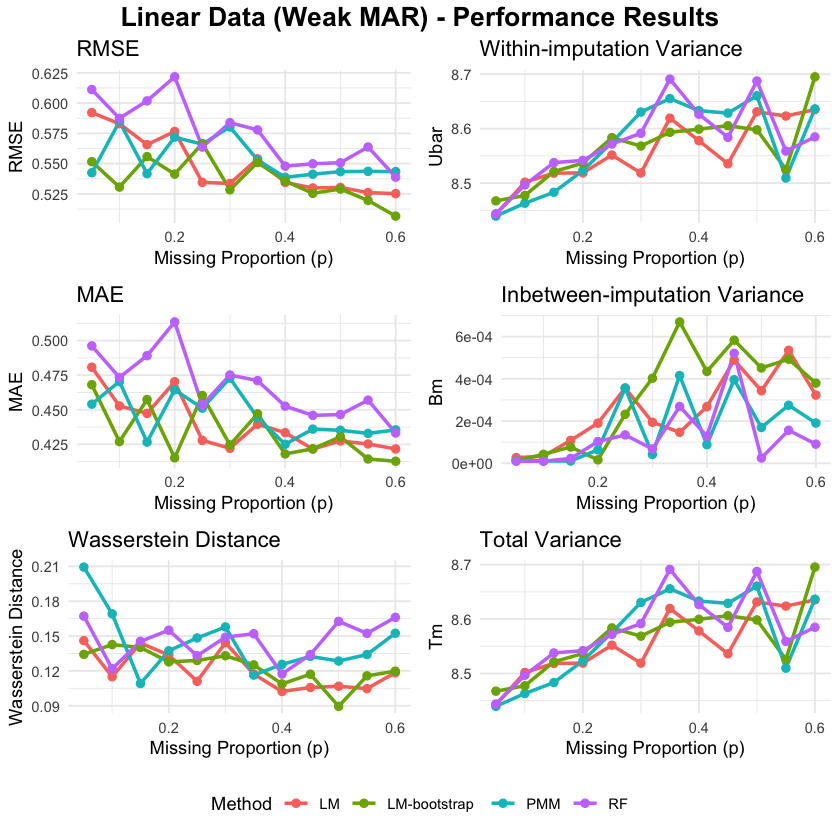

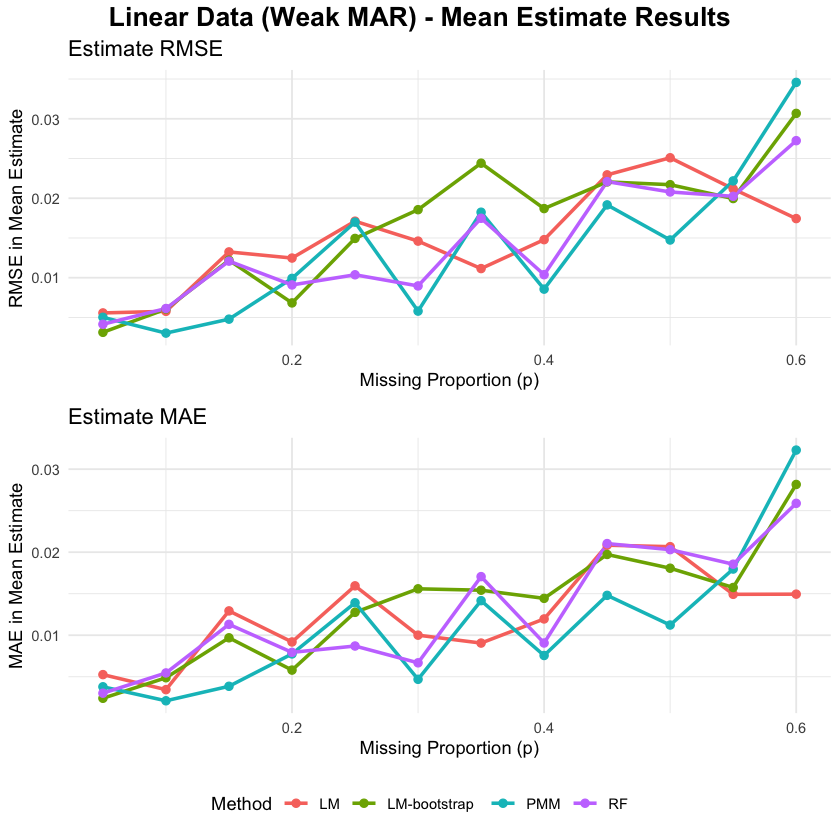

In [277]:
#### Plot for Linear Data wmar
linear_rmse_wmar_df <- melt(results_linear, id.vars = "missing_proportion", 
                measure.vars = c("rmse_lm_wmar", "rmse_pmm_wmar", "rmse_boot_wmar", "rmse_rf_wmar"),
                variable.name = "Method", value.name = "RMSE") %>%
  mutate(Method = gsub(".*_lm_wmar", "LM", Method), Method = gsub(".*_pmm_wmar", "PMM", Method), Method = gsub(".*_boot_wmar", "LM-bootstrap", Method), Method = gsub(".*_rf_wmar", "RF", Method))

linear_mae_wmar_df <- melt(results_linear, id.vars = "missing_proportion", 
               measure.vars = c("mae_lm_wmar", "mae_pmm_wmar", "mae_boot_wmar", "mae_rf_wmar"),
               variable.name = "Method", value.name = "MAE") %>%
  mutate(Method = gsub(".*_lm_wmar", "LM", Method), Method = gsub(".*_pmm_wmar", "PMM", Method), Method = gsub(".*_boot_wmar", "LM-bootstrap", Method), Method = gsub(".*_rf_wmar", "RF", Method))


linear_wasserstein_wmar_df <- melt(results_linear, id.vars = "missing_proportion", 
                       measure.vars = c("wasserstein_lm_wmar", "wasserstein_pmm_wmar", "wasserstein_boot_wmar", "wasserstein_rf_wmar"),
                       variable.name = "Method", value.name = "Wasserstein") %>%
  mutate(Method = gsub(".*_lm_wmar", "LM", Method), Method = gsub(".*_pmm_wmar", "PMM", Method), Method = gsub(".*_boot_wmar", "LM-bootstrap", Method), Method = gsub(".*_rf_wmar", "RF", Method))


linear_Ubar_wmar_df <- melt(results_linear, id.vars = "missing_proportion", 
                measure.vars = c("Ubar_lm_wmar", "Ubar_pmm_wmar", "Ubar_boot_wmar", "Ubar_rf_wmar"),
                variable.name = "Method", value.name = "Ubar") %>%
  mutate(Method = gsub(".*_lm_wmar", "LM", Method), Method = gsub(".*_pmm_wmar", "PMM", Method), Method = gsub(".*_boot_wmar", "LM-bootstrap", Method), Method = gsub(".*_rf_wmar", "RF", Method))


linear_Bm_wmar_df <- melt(results_linear, id.vars = "missing_proportion", 
               measure.vars = c("Bm_lm_wmar", "Bm_pmm_wmar", "Bm_boot_wmar", "Bm_rf_wmar"),
               variable.name = "Method", value.name = "Bm") %>%
  mutate(Method = gsub(".*_lm_wmar", "LM", Method), Method = gsub(".*_pmm_wmar", "PMM", Method), Method = gsub(".*_boot_wmar", "LM-bootstrap", Method), Method = gsub(".*_rf_wmar", "RF", Method))

 
linear_Tm_wmar_df <- melt(results_linear, id.vars = "missing_proportion", 
                       measure.vars = c("Tm_lm_wmar", "Tm_pmm_wmar", "Tm_boot_wmar", "Tm_rf_wmar"),
                       variable.name = "Method", value.name = "Tm") %>%
  mutate(Method = gsub(".*_lm_wmar", "LM", Method), Method = gsub(".*_pmm_wmar", "PMM", Method), Method = gsub(".*_boot_wmar", "LM-bootstrap", Method), Method = gsub(".*_rf_wmar", "RF", Method))

linear_estimate_rmse_wmar_df <- melt(results_linear, id.vars = "missing_proportion", 
                       measure.vars = c("estimate_rmse_lm_wmar", "estimate_rmse_pmm_wmar", "estimate_rmse_boot_wmar", "estimate_rmse_rf_wmar"),
                       variable.name = "Method", value.name = "Estimate RMSE") %>%
  mutate(Method = gsub(".*_lm_wmar", "LM", Method), Method = gsub(".*_pmm_wmar", "PMM", Method), Method = gsub(".*_boot_wmar", "LM-bootstrap", Method), Method = gsub(".*_rf_wmar", "RF", Method))

linear_estimate_mae_wmar_df <- melt(results_linear, id.vars = "missing_proportion", 
                       measure.vars = c("estimate_mae_lm_wmar", "estimate_mae_pmm_wmar", "estimate_mae_boot_wmar", "estimate_mae_rf_wmar"),
                       variable.name = "Method", value.name = "Estimate MAE") %>%
  mutate(Method = gsub(".*_lm_wmar", "LM", Method), Method = gsub(".*_pmm_wmar", "PMM", Method), Method = gsub(".*_boot_wmar", "LM-bootstrap", Method), Method = gsub(".*_rf_wmar", "RF", Method))

p1 <- ggplot(linear_rmse_wmar_df, aes(x = missing_proportion, y = RMSE, color = Method)) +
  geom_line(size = 1) + geom_point(size = 2) +
  labs(title = "RMSE", x = "Missing Proportion (p)", y = "RMSE") +
  theme_minimal() + theme(legend.position = "none")

p2 <- ggplot(linear_mae_wmar_df, aes(x = missing_proportion, y = MAE, color = Method)) +
  geom_line(size = 1) + geom_point(size = 2) +
  labs(title = "MAE", x = "Missing Proportion (p)", y = "MAE") +
  theme_minimal() + theme(legend.position = "none")

p3 <- ggplot(linear_wasserstein_wmar_df, aes(x = missing_proportion, y = Wasserstein, color = Method)) +
  geom_line(size = 1) + geom_point(size = 2) +
  labs(title = "Wasserstein Distance", x = "Missing Proportion (p)", y = "Wasserstein Distance") +
  theme_minimal() + theme(legend.position = "none")

p4 <- ggplot(linear_Ubar_wmar_df, aes(x = missing_proportion, y = Ubar, color = Method)) +
  geom_line(size = 1) + geom_point(size = 2) +
  labs(title = "Within-imputation Variance", x = "Missing Proportion (p)", y = "Ubar") +
  theme_minimal() + theme(legend.position = "none")

p5 <- ggplot(linear_Bm_wmar_df, aes(x = missing_proportion, y = Bm, color = Method)) +
  geom_line(size = 1) + geom_point(size = 2) +
  labs(title = "Inbetween-imputation Variance", x = "Missing Proportion (p)", y = "Bm") +
  theme_minimal() + theme(legend.position = "none")


p6 <- ggplot(linear_Tm_wmar_df, aes(x = missing_proportion, y = Tm, color = Method)) +
  geom_line(size = 1) + geom_point(size = 2) +
  labs(title = "Total Variance", x = "Missing Proportion (p)", y = "Tm") +
  theme_minimal() + theme(legend.position = "none")

p7 <- ggplot(linear_estimate_rmse_wmar_df, aes(x = missing_proportion, y = `Estimate RMSE`, color = Method)) +
  geom_line(size = 1) + geom_point(size = 2) +
  labs(title = "Estimate RMSE", x = "Missing Proportion (p)", y = "RMSE in Mean Estimate") +
  theme_minimal() + theme(legend.position = "none")

p8 <- ggplot(linear_estimate_mae_wmar_df, aes(x = missing_proportion, y = `Estimate MAE`, color = Method)) + 
  geom_line(size = 1) + geom_point(size = 2) +
  labs(title = "Estimate MAE", x = "Missing Proportion (p)", y = "MAE in Mean Estimate") +
  theme_minimal() + theme(legend.position = "none")

# Extract legend from last plot
get_legend <- function(plot) {
  g <- ggplotGrob(plot)
  legend <- g$grobs[[which(sapply(g$grobs, function(x) x$name) == "guide-box")]]
  return(legend)
}
legend <- get_legend(p1 + theme(legend.position = "bottom"))

# Arrange in a 3x2 layout with shared legend
grid.arrange(
  arrangeGrob(p1, p4, p2, p5, p3, p6, ncol = 2),
  legend,
  ncol = 1,  # Stack plots and legend vertically
  heights = c(10, 1),  
  top = textGrob("Linear Data (Weak MAR) - Performance Results", gp = gpar(fontsize = 16, fontface = "bold"))
)

grid.arrange(
  arrangeGrob(p7, p8, nrow = 2),
  legend,
  ncol = 1,  # Stack plots and legend vertically
  heights = c(10, 1),  
  top = textGrob("Linear Data (Weak MAR) - Mean Estimate Results", gp = gpar(fontsize = 16, fontface = "bold"))
)


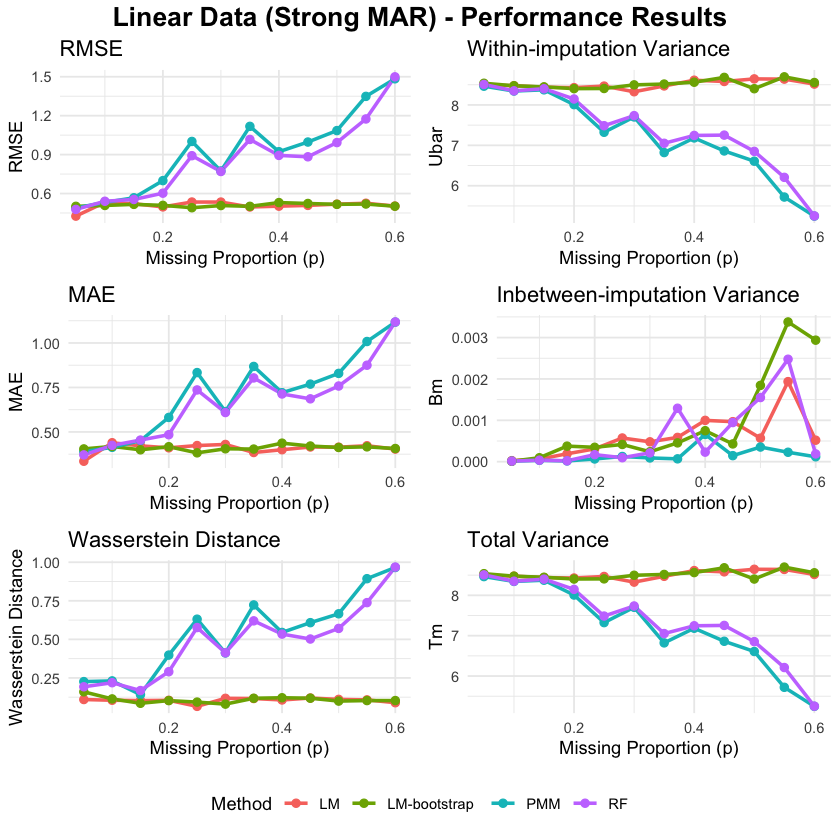

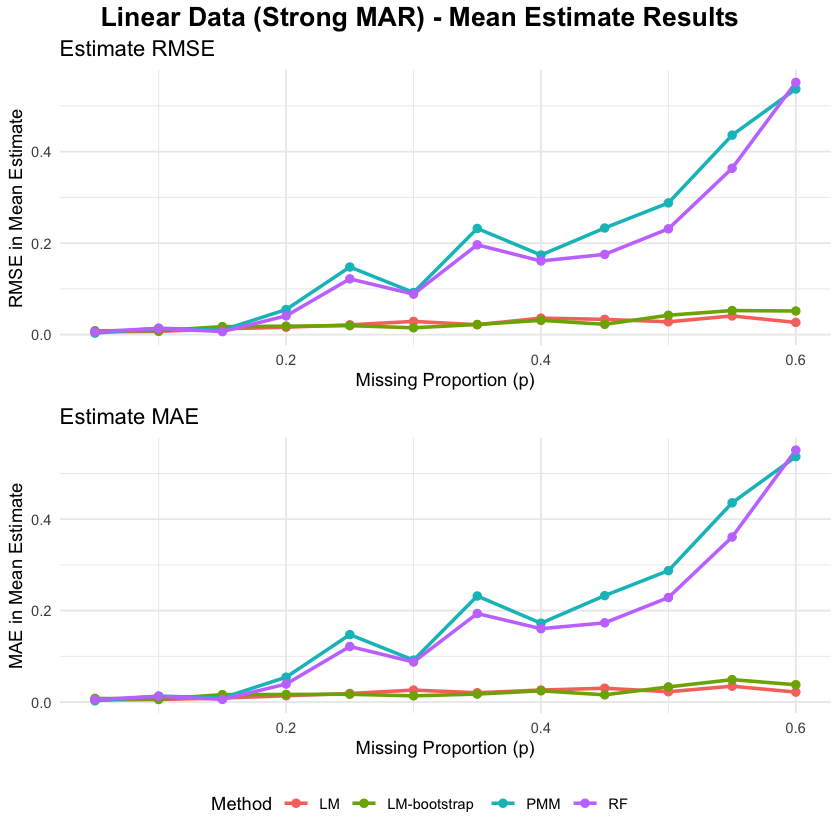

In [278]:
#### Plot for Linear Data MAR
linear_rmse_mar_df <- melt(results_linear, id.vars = "missing_proportion", 
                measure.vars = c("rmse_lm_mar", "rmse_pmm_mar", "rmse_boot_mar", "rmse_rf_mar"),
                variable.name = "Method", value.name = "RMSE") %>%
  mutate(Method = gsub(".*_lm_mar", "LM", Method), Method = gsub(".*_pmm_mar", "PMM", Method), Method = gsub(".*_boot_mar", "LM-bootstrap", Method), Method = gsub(".*_rf_mar", "RF", Method))

linear_mae_mar_df <- melt(results_linear, id.vars = "missing_proportion", 
               measure.vars = c("mae_lm_mar", "mae_pmm_mar", "mae_boot_mar", "mae_rf_mar"),
               variable.name = "Method", value.name = "MAE") %>%
  mutate(Method = gsub(".*_lm_mar", "LM", Method), Method = gsub(".*_pmm_mar", "PMM", Method), Method = gsub(".*_boot_mar", "LM-bootstrap", Method), Method = gsub(".*_rf_mar", "RF", Method))


linear_wasserstein_mar_df <- melt(results_linear, id.vars = "missing_proportion", 
                       measure.vars = c("wasserstein_lm_mar", "wasserstein_pmm_mar", "wasserstein_boot_mar", "wasserstein_rf_mar"),
                       variable.name = "Method", value.name = "Wasserstein") %>%
  mutate(Method = gsub(".*_lm_mar", "LM", Method), Method = gsub(".*_pmm_mar", "PMM", Method), Method = gsub(".*_boot_mar", "LM-bootstrap", Method), Method = gsub(".*_rf_mar", "RF", Method))


linear_Ubar_mar_df <- melt(results_linear, id.vars = "missing_proportion", 
                measure.vars = c("Ubar_lm_mar", "Ubar_pmm_mar", "Ubar_boot_mar", "Ubar_rf_mar"),
                variable.name = "Method", value.name = "Ubar") %>%
  mutate(Method = gsub(".*_lm_mar", "LM", Method), Method = gsub(".*_pmm_mar", "PMM", Method), Method = gsub(".*_boot_mar", "LM-bootstrap", Method), Method = gsub(".*_rf_mar", "RF", Method))


linear_Bm_mar_df <- melt(results_linear, id.vars = "missing_proportion", 
               measure.vars = c("Bm_lm_mar", "Bm_pmm_mar", "Bm_boot_mar", "Bm_rf_mar"),
               variable.name = "Method", value.name = "Bm") %>%
  mutate(Method = gsub(".*_lm_mar", "LM", Method), Method = gsub(".*_pmm_mar", "PMM", Method), Method = gsub(".*_boot_mar", "LM-bootstrap", Method), Method = gsub(".*_rf_mar", "RF", Method))

 
linear_Tm_mar_df <- melt(results_linear, id.vars = "missing_proportion", 
                       measure.vars = c("Tm_lm_mar", "Tm_pmm_mar", "Tm_boot_mar", "Tm_rf_mar"),
                       variable.name = "Method", value.name = "Tm") %>%
  mutate(Method = gsub(".*_lm_mar", "LM", Method), Method = gsub(".*_pmm_mar", "PMM", Method), Method = gsub(".*_boot_mar", "LM-bootstrap", Method), Method = gsub(".*_rf_mar", "RF", Method))

linear_estimate_rmse_mar_df <- melt(results_linear, id.vars = "missing_proportion", 
                       measure.vars = c("estimate_rmse_lm_mar", "estimate_rmse_pmm_mar", "estimate_rmse_boot_mar", "estimate_rmse_rf_mar"),
                       variable.name = "Method", value.name = "Estimate RMSE") %>%
  mutate(Method = gsub(".*_lm_mar", "LM", Method), Method = gsub(".*_pmm_mar", "PMM", Method), Method = gsub(".*_boot_mar", "LM-bootstrap", Method), Method = gsub(".*_rf_mar", "RF", Method))

linear_estimate_mae_mar_df <- melt(results_linear, id.vars = "missing_proportion", 
                       measure.vars = c("estimate_mae_lm_mar", "estimate_mae_pmm_mar", "estimate_mae_boot_mar", "estimate_mae_rf_mar"),
                       variable.name = "Method", value.name = "Estimate MAE") %>%
  mutate(Method = gsub(".*_lm_mar", "LM", Method), Method = gsub(".*_pmm_mar", "PMM", Method), Method = gsub(".*_boot_mar", "LM-bootstrap", Method), Method = gsub(".*_rf_mar", "RF", Method))


p1 <- ggplot(linear_rmse_mar_df, aes(x = missing_proportion, y = RMSE, color = Method)) +
  geom_line(size = 1) + geom_point(size = 2) +
  labs(title = "RMSE", x = "Missing Proportion (p)", y = "RMSE") +
  theme_minimal() + theme(legend.position = "none")

p2 <- ggplot(linear_mae_mar_df, aes(x = missing_proportion, y = MAE, color = Method)) +
  geom_line(size = 1) + geom_point(size = 2) +
  labs(title = "MAE", x = "Missing Proportion (p)", y = "MAE") +
  theme_minimal() + theme(legend.position = "none")

p3 <- ggplot(linear_wasserstein_mar_df, aes(x = missing_proportion, y = Wasserstein, color = Method)) +
  geom_line(size = 1) + geom_point(size = 2) +
  labs(title = "Wasserstein Distance", x = "Missing Proportion (p)", y = "Wasserstein Distance") +
  theme_minimal() + theme(legend.position = "none")

p4 <- ggplot(linear_Ubar_mar_df, aes(x = missing_proportion, y = Ubar, color = Method)) +
  geom_line(size = 1) + geom_point(size = 2) +
  labs(title = "Within-imputation Variance", x = "Missing Proportion (p)", y = "Ubar") +
  theme_minimal() + theme(legend.position = "none")

p5 <- ggplot(linear_Bm_mar_df, aes(x = missing_proportion, y = Bm, color = Method)) +
  geom_line(size = 1) + geom_point(size = 2) +
  labs(title = "Inbetween-imputation Variance", x = "Missing Proportion (p)", y = "Bm") +
  theme_minimal() + theme(legend.position = "none")


p6 <- ggplot(linear_Tm_mar_df, aes(x = missing_proportion, y = Tm, color = Method)) +
  geom_line(size = 1) + geom_point(size = 2) +
  labs(title = "Total Variance", x = "Missing Proportion (p)", y = "Tm") +
  theme_minimal() + theme(legend.position = "none")

p7 <- ggplot(linear_estimate_rmse_mar_df, aes(x = missing_proportion, y = `Estimate RMSE`, color = Method)) + 
  geom_line(size = 1) + geom_point(size = 2) +
  labs(title = "Estimate RMSE", x = "Missing Proportion (p)", y = "RMSE in Mean Estimate") +
  theme_minimal() + theme(legend.position = "none")

p8 <- ggplot(linear_estimate_mae_mar_df, aes(x = missing_proportion, y = `Estimate MAE`, color = Method)) + 
  geom_line(size = 1) + geom_point(size = 2) +
  labs(title = "Estimate MAE", x = "Missing Proportion (p)", y = "MAE in Mean Estimate") +
  theme_minimal() + theme(legend.position = "none")


# Extract legend from last plot
get_legend <- function(plot) {
  g <- ggplotGrob(plot)
  legend <- g$grobs[[which(sapply(g$grobs, function(x) x$name) == "guide-box")]]
  return(legend)
}
legend <- get_legend(p1 + theme(legend.position = "bottom"))

# Arrange in a 3x2 layout with shared legend
grid.arrange(
  arrangeGrob(p1, p4, p2, p5, p3, p6, ncol = 2),
  legend,
  ncol = 1,  
  heights = c(10, 1),  
  top = textGrob("Linear Data (Strong MAR) - Performance Results", gp = gpar(fontsize = 16, fontface = "bold"))
)

grid.arrange(
  arrangeGrob(p7, p8, nrow = 2),
  legend,
  ncol = 1,  
  heights = c(10, 1),  
  top = textGrob("Linear Data (Strong MAR) - Mean Estimate Results", gp = gpar(fontsize = 16, fontface = "bold"))
)






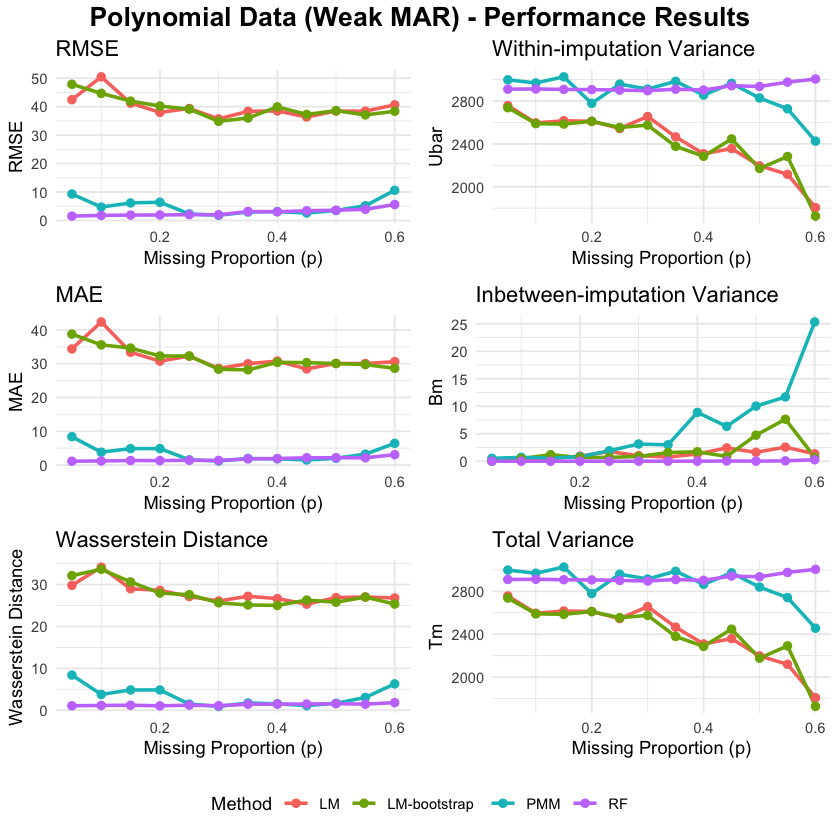

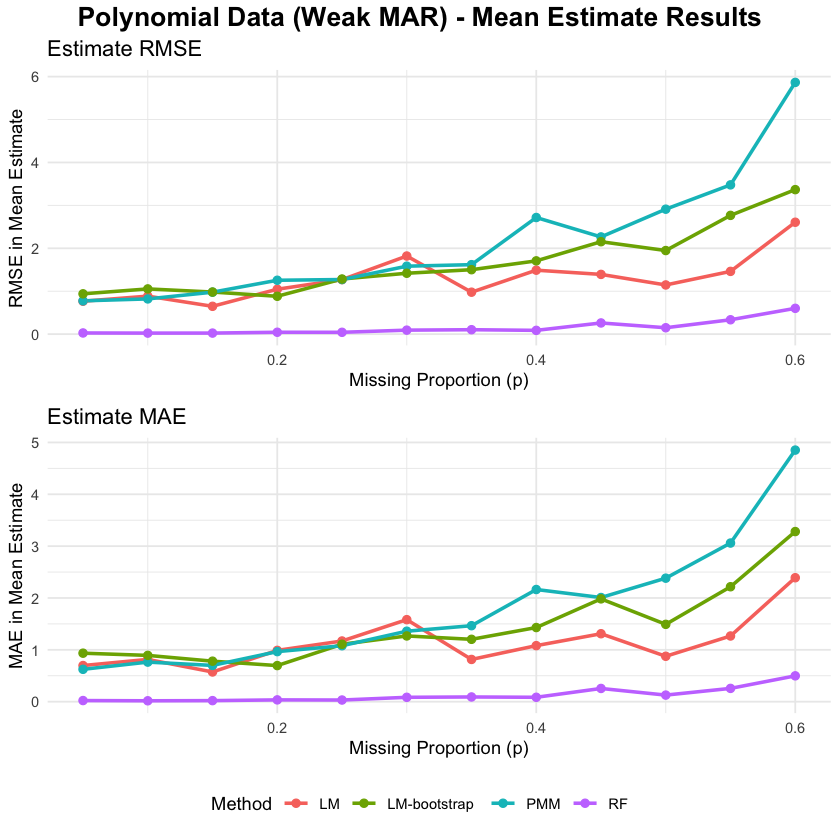

In [284]:
#### Plot for Polynomial Data wmar
poly_rmse_wmar_df <- melt(results_poly, id.vars = "missing_proportion", 
                measure.vars = c("rmse_lm_wmar", "rmse_pmm_wmar", "rmse_boot_wmar", "rmse_rf_wmar"),
                variable.name = "Method", value.name = "RMSE") %>%
  mutate(Method = gsub(".*_lm_wmar", "LM", Method), Method = gsub(".*_pmm_wmar", "PMM", Method), Method = gsub(".*_boot_wmar", "LM-bootstrap", Method), Method = gsub(".*_rf_wmar", "RF", Method))

poly_mae_wmar_df <- melt(results_poly, id.vars = "missing_proportion", 
               measure.vars = c("mae_lm_wmar", "mae_pmm_wmar", "mae_boot_wmar", "mae_rf_wmar"),
               variable.name = "Method", value.name = "MAE") %>%
  mutate(Method = gsub(".*_lm_wmar", "LM", Method), Method = gsub(".*_pmm_wmar", "PMM", Method), Method = gsub(".*_boot_wmar", "LM-bootstrap", Method), Method = gsub(".*_rf_wmar", "RF", Method))

poly_wasserstein_wmar_df <- melt(results_poly, id.vars = "missing_proportion", 
                       measure.vars = c("wasserstein_lm_wmar", "wasserstein_pmm_wmar", "wasserstein_boot_wmar", "wasserstein_rf_wmar"),
                       variable.name = "Method", value.name = "Wasserstein") %>%
  mutate(Method = gsub(".*_lm_wmar", "LM", Method), Method = gsub(".*_pmm_wmar", "PMM", Method), Method = gsub(".*_boot_wmar", "LM-bootstrap", Method), Method = gsub(".*_rf_wmar", "RF", Method))

poly_Ubar_wmar_df <- melt(results_poly, id.vars = "missing_proportion", 
                measure.vars = c("Ubar_lm_wmar", "Ubar_pmm_wmar", "Ubar_boot_wmar", "Ubar_rf_wmar"),
                variable.name = "Method", value.name = "Ubar") %>%
  mutate(Method = gsub(".*_lm_wmar", "LM", Method), Method = gsub(".*_pmm_wmar", "PMM", Method), Method = gsub(".*_boot_wmar", "LM-bootstrap", Method), Method = gsub(".*_rf_wmar", "RF", Method))

poly_Bm_wmar_df <- melt(results_poly, id.vars = "missing_proportion", 
               measure.vars = c("Bm_lm_wmar", "Bm_pmm_wmar", "Bm_boot_wmar", "Bm_rf_wmar"),
               variable.name = "Method", value.name = "Bm") %>%
  mutate(Method = gsub(".*_lm_wmar", "LM", Method), Method = gsub(".*_pmm_wmar", "PMM", Method), Method = gsub(".*_boot_wmar", "LM-bootstrap", Method), Method = gsub(".*_rf_wmar", "RF", Method))

poly_Tm_wmar_df <- melt(results_poly, id.vars = "missing_proportion", 
                       measure.vars = c("Tm_lm_wmar", "Tm_pmm_wmar", "Tm_boot_wmar", "Tm_rf_wmar"),
                       variable.name = "Method", value.name = "Tm") %>%
  mutate(Method = gsub(".*_lm_wmar", "LM", Method), Method = gsub(".*_pmm_wmar", "PMM", Method), Method = gsub(".*_boot_wmar", "LM-bootstrap", Method), Method = gsub(".*_rf_wmar", "RF", Method))

poly_estimate_rmse_wmar_df <- melt(results_poly, id.vars = "missing_proportion", 
                       measure.vars = c("estimate_rmse_lm_wmar", "estimate_rmse_pmm_wmar", "estimate_rmse_boot_wmar", "estimate_rmse_rf_wmar"),
                       variable.name = "Method", value.name = "Estimate RMSE") %>%
  mutate(Method = gsub(".*_lm_wmar", "LM", Method), Method = gsub(".*_pmm_wmar", "PMM", Method), Method = gsub(".*_boot_wmar", "LM-bootstrap", Method), Method = gsub(".*_rf_wmar", "RF", Method))

poly_estimate_mae_wmar_df <- melt(results_poly, id.vars = "missing_proportion", 
                       measure.vars = c("estimate_mae_lm_wmar", "estimate_mae_pmm_wmar", "estimate_mae_boot_wmar", "estimate_mae_rf_wmar"),
                       variable.name = "Method", value.name = "Estimate MAE") %>%
  mutate(Method = gsub(".*_lm_wmar", "LM", Method), Method = gsub(".*_pmm_wmar", "PMM", Method), Method = gsub(".*_boot_wmar", "LM-bootstrap", Method), Method = gsub(".*_rf_wmar", "RF", Method))

p1 <- ggplot(poly_rmse_wmar_df, aes(x = missing_proportion, y = RMSE, color = Method)) +
  geom_line(size = 1) + geom_point(size = 2) +
  labs(title = "RMSE", x = "Missing Proportion (p)", y = "RMSE") +
  theme_minimal() + theme(legend.position = "none")

p2 <- ggplot(poly_mae_wmar_df, aes(x = missing_proportion, y = MAE, color = Method)) +
  geom_line(size = 1) + geom_point(size = 2) +
  labs(title = "MAE", x = "Missing Proportion (p)", y = "MAE") +
  theme_minimal() + theme(legend.position = "none")

p3 <- ggplot(poly_wasserstein_wmar_df, aes(x = missing_proportion, y = Wasserstein, color = Method)) +
  geom_line(size = 1) + geom_point(size = 2) +
  labs(title = "Wasserstein Distance", x = "Missing Proportion (p)", y = "Wasserstein Distance") +
  theme_minimal() + theme(legend.position = "none")

p4 <- ggplot(poly_Ubar_wmar_df, aes(x = missing_proportion, y = Ubar, color = Method)) +
  geom_line(size = 1) + geom_point(size = 2) +
  labs(title = "Within-imputation Variance", x = "Missing Proportion (p)", y = "Ubar") +
  theme_minimal() + theme(legend.position = "none")

p5 <- ggplot(poly_Bm_wmar_df, aes(x = missing_proportion, y = Bm, color = Method)) +
  geom_line(size = 1) + geom_point(size = 2) +
  labs(title = "Inbetween-imputation Variance", x = "Missing Proportion (p)", y = "Bm") +
  theme_minimal() + theme(legend.position = "none")

p6 <- ggplot(poly_Tm_wmar_df, aes(x = missing_proportion, y = Tm, color = Method)) +
  geom_line(size = 1) + geom_point(size = 2) +
  labs(title = "Total Variance", x = "Missing Proportion (p)", y = "Tm") +
  theme_minimal() + theme(legend.position = "none")

p7 <- ggplot(poly_estimate_rmse_wmar_df, aes(x = missing_proportion, y = `Estimate RMSE`, color = Method)) +
  geom_line(size = 1) + geom_point(size = 2) +
  labs(title = "Estimate RMSE", x = "Missing Proportion (p)", y = "RMSE in Mean Estimate") +
  theme_minimal() + theme(legend.position = "none")

p8 <- ggplot(poly_estimate_mae_wmar_df, aes(x = missing_proportion, y = `Estimate MAE`, color = Method)) +
  geom_line(size = 1) + geom_point(size = 2) +
  labs(title = "Estimate MAE", x = "Missing Proportion (p)", y = "MAE in Mean Estimate") +
  theme_minimal() + theme(legend.position = "none")

legend1 <- get_legend(p6 + theme(legend.position = "bottom"))

legend2 <- get_legend(p8 + theme(legend.position = "bottom"))

# Arrange in a 3x2 layout with shared legend
grid.arrange(
  arrangeGrob(p1, p4, p2, p5, p3, p6, ncol = 2),
  legend,
  ncol = 1,  # Stack plots and legend vertically
  heights = c(10, 1),  
  top = textGrob("Polynomial Data (Weak MAR) - Performance Results", gp = gpar(fontsize = 16, fontface = "bold"))
)

grid.arrange(
  arrangeGrob(p7, p8, nrow = 2),
  legend2,
  ncol = 1,  # Stack plots and legend vertically
  heights = c(10, 1),  
  top = textGrob("Polynomial Data (Weak MAR) - Mean Estimate Results", gp = gpar(fontsize = 16, fontface = "bold"))
)


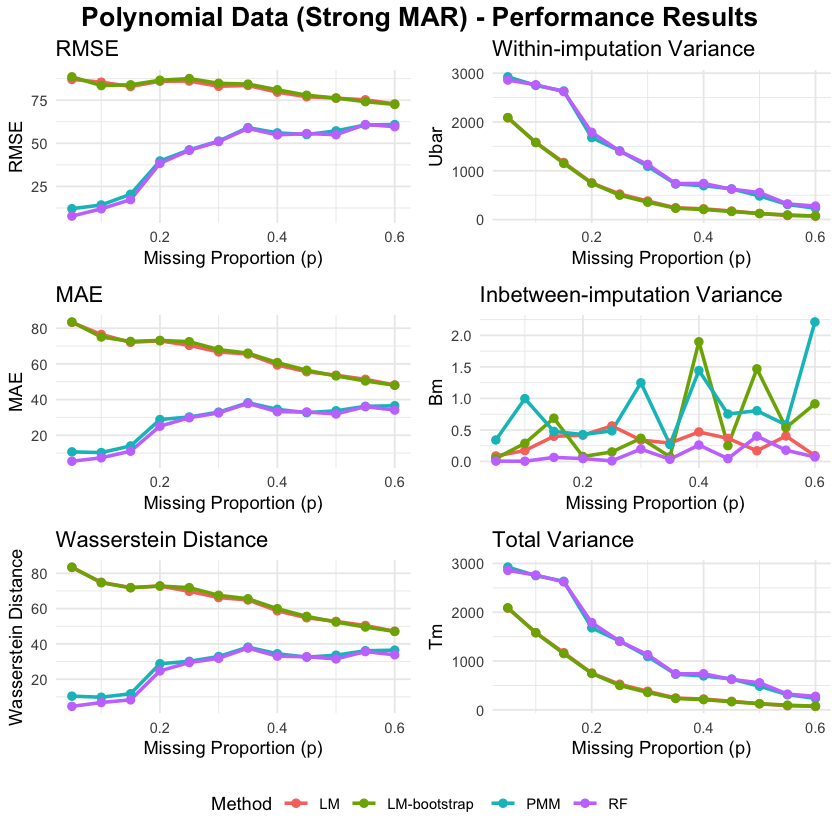

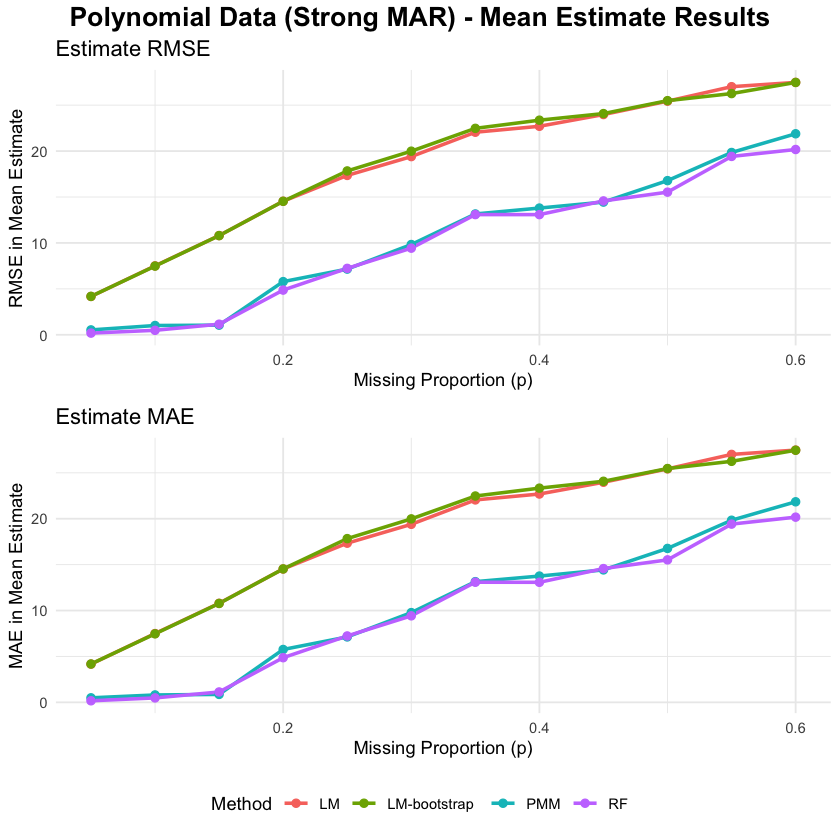

In [280]:
#### Plot for Polynomial Data MAR
poly_rmse_mar_df <- melt(results_poly, id.vars = "missing_proportion", 
                measure.vars = c("rmse_lm_mar", "rmse_pmm_mar", "rmse_boot_mar", "rmse_rf_mar"),
                variable.name = "Method", value.name = "RMSE") %>%
  mutate(Method = gsub(".*_lm_mar", "LM", Method), Method = gsub(".*_pmm_mar", "PMM", Method), Method = gsub(".*_boot_mar", "LM-bootstrap", Method), Method = gsub(".*_rf_mar", "RF", Method))

poly_mae_mar_df <- melt(results_poly, id.vars = "missing_proportion", 
               measure.vars = c("mae_lm_mar", "mae_pmm_mar", "mae_boot_mar", "mae_rf_mar"),
               variable.name = "Method", value.name = "MAE") %>%
  mutate(Method = gsub(".*_lm_mar", "LM", Method), Method = gsub(".*_pmm_mar", "PMM", Method), Method = gsub(".*_boot_mar", "LM-bootstrap", Method), Method = gsub(".*_rf_mar", "RF", Method))

poly_wasserstein_mar_df <- melt(results_poly, id.vars = "missing_proportion", 
                       measure.vars = c("wasserstein_lm_mar", "wasserstein_pmm_mar", "wasserstein_boot_mar", "wasserstein_rf_mar"),
                       variable.name = "Method", value.name = "Wasserstein") %>%
  mutate(Method = gsub(".*_lm_mar", "LM", Method), Method = gsub(".*_pmm_mar", "PMM", Method), Method = gsub(".*_boot_mar", "LM-bootstrap", Method), Method = gsub(".*_rf_mar", "RF", Method))

poly_Ubar_mar_df <- melt(results_poly, id.vars = "missing_proportion", 
                measure.vars = c("Ubar_lm_mar", "Ubar_pmm_mar", "Ubar_boot_mar", "Ubar_rf_mar"),
                variable.name = "Method", value.name = "Ubar") %>%
  mutate(Method = gsub(".*_lm_mar", "LM", Method), Method = gsub(".*_pmm_mar", "PMM", Method), Method = gsub(".*_boot_mar", "LM-bootstrap", Method), Method = gsub(".*_rf_mar", "RF", Method))

poly_Bm_mar_df <- melt(results_poly, id.vars = "missing_proportion", 
               measure.vars = c("Bm_lm_mar", "Bm_pmm_mar", "Bm_boot_mar", "Bm_rf_mar"),
               variable.name = "Method", value.name = "Bm") %>%
  mutate(Method = gsub(".*_lm_mar", "LM", Method), Method = gsub(".*_pmm_mar", "PMM", Method), Method = gsub(".*_boot_mar", "LM-bootstrap", Method), Method = gsub(".*_rf_mar", "RF", Method))

poly_Tm_mar_df <- melt(results_poly, id.vars = "missing_proportion", 
                       measure.vars = c("Tm_lm_mar", "Tm_pmm_mar", "Tm_boot_mar", "Tm_rf_mar"),
                       variable.name = "Method", value.name = "Tm") %>% 
  mutate(Method = gsub(".*_lm_mar", "LM", Method), Method = gsub(".*_pmm_mar", "PMM", Method), Method = gsub(".*_boot_mar", "LM-bootstrap", Method), Method = gsub(".*_rf_mar", "RF", Method))

poly_estimate_rmse_mar_df <- melt(results_poly, id.vars = "missing_proportion", 
                       measure.vars = c("estimate_rmse_lm_mar", "estimate_rmse_pmm_mar", "estimate_rmse_boot_mar", "estimate_rmse_rf_mar"),
                       variable.name = "Method", value.name = "Estimate RMSE") %>%
  mutate(Method = gsub(".*_lm_mar", "LM", Method), Method = gsub(".*_pmm_mar", "PMM", Method), Method = gsub(".*_boot_mar", "LM-bootstrap", Method), Method = gsub(".*_rf_mar", "RF", Method))

poly_estimate_mae_mar_df <- melt(results_poly, id.vars = "missing_proportion", 
                       measure.vars = c("estimate_mae_lm_mar", "estimate_mae_pmm_mar", "estimate_mae_boot_mar", "estimate_mae_rf_mar"),
                       variable.name = "Method", value.name = "Estimate MAE") %>%
  mutate(Method = gsub(".*_lm_mar", "LM", Method), Method = gsub(".*_pmm_mar", "PMM", Method), Method = gsub(".*_boot_mar", "LM-bootstrap", Method), Method = gsub(".*_rf_mar", "RF", Method))

p1 <- ggplot(poly_rmse_mar_df, aes(x = missing_proportion, y = RMSE, color = Method)) +
  geom_line(size = 1) + geom_point(size = 2) +
  labs(title = "RMSE", x = "Missing Proportion (p)", y = "RMSE") +
  theme_minimal() + theme(legend.position = "none")

p2 <- ggplot(poly_mae_mar_df, aes(x = missing_proportion, y = MAE, color = Method)) +
  geom_line(size = 1) + geom_point(size = 2) +
  labs(title = "MAE", x = "Missing Proportion (p)", y = "MAE") +
  theme_minimal() + theme(legend.position = "none")

p3 <- ggplot(poly_wasserstein_mar_df, aes(x = missing_proportion, y = Wasserstein, color = Method)) +
  geom_line(size = 1) + geom_point(size = 2) +
  labs(title = "Wasserstein Distance", x = "Missing Proportion (p)", y = "Wasserstein Distance") +
  theme_minimal() + theme(legend.position = "none")

p4 <- ggplot(poly_Ubar_mar_df, aes(x = missing_proportion, y = Ubar, color = Method)) +
  geom_line(size = 1) + geom_point(size = 2) +
  labs(title = "Within-imputation Variance", x = "Missing Proportion (p)", y = "Ubar") +
  theme_minimal() + theme(legend.position = "none")

p5 <- ggplot(poly_Bm_mar_df, aes(x = missing_proportion, y = Bm, color = Method)) +
  geom_line(size = 1) + geom_point(size = 2) +
  labs(title = "Inbetween-imputation Variance", x = "Missing Proportion (p)", y = "Bm") +
  theme_minimal() + theme(legend.position = "none")

p6 <- ggplot(poly_Tm_mar_df, aes(x = missing_proportion, y = Tm, color = Method)) +
  geom_line(size = 1) + geom_point(size = 2) +
  labs(title = "Total Variance", x = "Missing Proportion (p)", y = "Tm") +
  theme_minimal() + theme(legend.position = "none")

p7 <- ggplot(poly_estimate_rmse_mar_df, aes(x = missing_proportion, y = `Estimate RMSE`, color = Method)) + 
  geom_line(size = 1) + geom_point(size = 2) +
  labs(title = "Estimate RMSE", x = "Missing Proportion (p)", y = "RMSE in Mean Estimate") +
  theme_minimal() + theme(legend.position = "none")

p8 <- ggplot(poly_estimate_mae_mar_df, aes(x = missing_proportion, y = `Estimate MAE`, color = Method)) + 
  geom_line(size = 1) + geom_point(size = 2) +
  labs(title = "Estimate MAE", x = "Missing Proportion (p)", y = "MAE in Mean Estimate") +
  theme_minimal() + theme(legend.position = "none")

legend <- get_legend(p1 + theme(legend.position = "bottom"))

# Arrange in a 3x2 layout with shared legend
grid.arrange(
  arrangeGrob(p1, p4, p2, p5, p3, p6, ncol = 2),
  legend,
  ncol = 1,  # Stack plots and legend vertically
  heights = c(10, 1),  
  top = textGrob("Polynomial Data (Strong MAR) - Performance Results", gp = gpar(fontsize = 16, fontface = "bold"))
)

grid.arrange(
  arrangeGrob(p7, p8, nrow = 2),
  legend,
  ncol = 1,  # Stack plots and legend vertically
  heights = c(10, 1),  
  top = textGrob("Polynomial Data (Strong MAR) - Mean Estimate Results", gp = gpar(fontsize = 16, fontface = "bold"))
)




In [281]:
# #### Plot for Nonlinear Data wmar
# nonlinear_rmse_wmar_df <- melt(results_nonlinear, id.vars = "missing_proportion", 
#                 measure.vars = c("rmse_lm_wmar", "rmse_pmm_wmar", "rmse_boot_wmar", "rmse_rf_wmar"),
#                 variable.name = "Method", value.name = "RMSE") %>%
#   mutate(Method = gsub(".*_lm_wmar", "LM", Method), 
#          Method = gsub(".*_pmm_wmar", "PMM", Method), 
#          Method = gsub(".*_boot_wmar", "LM-bootstrap", Method), 
#          Method = gsub(".*_rf_wmar", "RF", Method))

# nonlinear_mae_wmar_df <- melt(results_nonlinear, id.vars = "missing_proportion", 
#                measure.vars = c("mae_lm_wmar", "mae_pmm_wmar", "mae_boot_wmar", "mae_rf_wmar"),
#                variable.name = "Method", value.name = "MAE") %>%
#   mutate(Method = gsub(".*_lm_wmar", "LM", Method), 
#          Method = gsub(".*_pmm_wmar", "PMM", Method), 
#          Method = gsub(".*_boot_wmar", "LM-bootstrap", Method), 
#          Method = gsub(".*_rf_wmar", "RF", Method))

# nonlinear_wasserstein_wmar_df <- melt(results_nonlinear, id.vars = "missing_proportion", 
#                        measure.vars = c("wasserstein_lm_wmar", "wasserstein_pmm_wmar", "wasserstein_boot_wmar", "wasserstein_rf_wmar"),
#                        variable.name = "Method", value.name = "Wasserstein") %>%
#   mutate(Method = gsub(".*_lm_wmar", "LM", Method), 
#          Method = gsub(".*_pmm_wmar", "PMM", Method), 
#          Method = gsub(".*_boot_wmar", "LM-bootstrap", Method), 
#          Method = gsub(".*_rf_wmar", "RF", Method))

# nonlinear_Ubar_wmar_df <- melt(results_nonlinear, id.vars = "missing_proportion", 
#                 measure.vars = c("Ubar_lm_wmar", "Ubar_pmm_wmar", "Ubar_boot_wmar", "Ubar_rf_wmar"),
#                 variable.name = "Method", value.name = "Ubar") %>%
#   mutate(Method = gsub(".*_lm_wmar", "LM", Method), 
#          Method = gsub(".*_pmm_wmar", "PMM", Method), 
#          Method = gsub(".*_boot_wmar", "LM-bootstrap", Method), 
#          Method = gsub(".*_rf_wmar", "RF", Method))

# nonlinear_Bm_wmar_df <- melt(results_nonlinear, id.vars = "missing_proportion", 
#                measure.vars = c("Bm_lm_wmar", "Bm_pmm_wmar", "Bm_boot_wmar", "Bm_rf_wmar"),
#                variable.name = "Method", value.name = "Bm") %>%
#   mutate(Method = gsub(".*_lm_wmar", "LM", Method), 
#          Method = gsub(".*_pmm_wmar", "PMM", Method), 
#          Method = gsub(".*_boot_wmar", "LM-bootstrap", Method), 
#          Method = gsub(".*_rf_wmar", "RF", Method))

# nonlinear_Tm_wmar_df <- melt(results_nonlinear, id.vars = "missing_proportion", 
#                        measure.vars = c("Tm_lm_wmar", "Tm_pmm_wmar", "Tm_boot_wmar", "Tm_rf_wmar"),
#                        variable.name = "Method", value.name = "Tm") %>%
#   mutate(Method = gsub(".*_lm_wmar", "LM", Method), 
#          Method = gsub(".*_pmm_wmar", "PMM", Method), 
#          Method = gsub(".*_boot_wmar", "LM-bootstrap", Method), 
#          Method = gsub(".*_rf_wmar", "RF", Method))

# nonlinear_estimate_rmse_wmar_df <- melt(results_nonlinear, id.vars = "missing_proportion", 
#                        measure.vars = c("estimate_rmse_lm_wmar", "estimate_rmse_pmm_wmar", "estimate_rmse_boot_wmar", "estimate_rmse_rf_wmar"),
#                        variable.name = "Method", value.name = "Estimate RMSE") %>%
#   mutate(Method = gsub(".*_lm_wmar", "LM", Method), 
#          Method = gsub(".*_pmm_wmar", "PMM", Method), 
#          Method = gsub(".*_boot_wmar", "LM-bootstrap", Method), 
#          Method = gsub(".*_rf_wmar", "RF", Method))

# nonlinear_estimate_mae_wmar_df <- melt(results_nonlinear, id.vars = "missing_proportion", 
#                        measure.vars = c("estimate_mae_lm_wmar", "estimate_mae_pmm_wmar", "estimate_mae_boot_wmar", "estimate_mae_rf_wmar"),
#                        variable.name = "Method", value.name = "Estimate MAE") %>%
#   mutate(Method = gsub(".*_lm_wmar", "LM", Method), 
#          Method = gsub(".*_pmm_wmar", "PMM", Method), 
#          Method = gsub(".*_boot_wmar", "LM-bootstrap", Method), 
#          Method = gsub(".*_rf_wmar", "RF", Method))

# p1 <- ggplot(nonlinear_rmse_wmar_df, aes(x = missing_proportion, y = RMSE, color = Method)) +
#   geom_line(size = 1) + geom_point(size = 2) +
#   labs(title = "RMSE", x = "Missing Proportion (p)", y = "RMSE") +
#   theme_minimal() + theme(legend.position = "none")

# p2 <- ggplot(nonlinear_mae_wmar_df, aes(x = missing_proportion, y = MAE, color = Method)) +
#   geom_line(size = 1) + geom_point(size = 2) +
#   labs(title = "MAE", x = "Missing Proportion (p)", y = "MAE") +
#   theme_minimal() + theme(legend.position = "none")

# p3 <- ggplot(nonlinear_wasserstein_wmar_df, aes(x = missing_proportion, y = Wasserstein, color = Method)) +
#   geom_line(size = 1) + geom_point(size = 2) +
#   labs(title = "Wasserstein Distance", x = "Missing Proportion (p)", y = "Wasserstein Distance") +
#   theme_minimal() + theme(legend.position = "none")

# p4 <- ggplot(nonlinear_Ubar_wmar_df, aes(x = missing_proportion, y = Ubar, color = Method)) +
#   geom_line(size = 1) + geom_point(size = 2) +
#   labs(title = "Within-imputation Variance", x = "Missing Proportion (p)", y = "Ubar") +
#   theme_minimal() + theme(legend.position = "none")

# p5 <- ggplot(nonlinear_Bm_wmar_df, aes(x = missing_proportion, y = Bm, color = Method)) +
#   geom_line(size = 1) + geom_point(size = 2) +
#   labs(title = "Inbetween-imputation Variance", x = "Missing Proportion (p)", y = "Bm") +
#   theme_minimal() + theme(legend.position = "none")
 
# p6 <- ggplot(nonlinear_Tm_wmar_df, aes(x = missing_proportion, y = Tm, color = Method)) +
#   geom_line(size = 1) + geom_point(size = 2) +
#   labs(title = "Total Variance", x = "Missing Proportion (p)", y = "Tm") +
#   theme_minimal() + theme(legend.position = "none")

# p7 <- ggplot(nonlinear_estimate_rmse_wmar_df, aes(x = missing_proportion, y = `Estimate RMSE`, color = Method)) + 
#   geom_line(size = 1) + geom_point(size = 2) +
#   labs(title = "Estimate RMSE", x = "Missing Proportion (p)", y = "RMSE in Mean Estimate") +
#   theme_minimal() + theme(legend.position = "none")

# p8 <- ggplot(nonlinear_estimate_mae_wmar_df, aes(x = missing_proportion, y = `Estimate MAE`, color = Method)) +
#   geom_line(size = 1) + geom_point(size = 2) +
#   labs(title = "Estimate MAE", x = "Missing Proportion (p)", y = "MAE in Mean Estimate") +
#   theme_minimal() + theme(legend.position = "none")


# legend <- get_legend(p6 + theme(legend.position = "bottom"))

# # Arrange in a 3x2 layout with shared legend
# grid.arrange(
#   arrangeGrob(p1, p4, p2, p5, p3, p6, ncol = 2),
#   legend,
#   ncol = 1,  # Stack plots and legend vertically
#   heights = c(10, 1),  
#   top = textGrob("Nonlinear Data (wmar) - Performance Results", gp = gpar(fontsize = 16, fontface = "bold"))
# )

# grid.arrange(
#   arrangeGrob(p7, p8, nrow = 2),
#   legend,
#   ncol = 1,  # Stack plots and legend vertically
#   heights = c(10, 1),  
#   top = textGrob("Nonlinear Data (wmar) - Mean Estimate Results", gp = gpar(fontsize = 16, fontface = "bold"))
# )


In [282]:
# #### Plot for Nonlinear Data MAR
# nonlinear_rmse_mar_df <- melt(results_nonlinear, id.vars = "missing_proportion", 
#                 measure.vars = c("rmse_lm_mar", "rmse_pmm_mar", "rmse_boot_mar", "rmse_rf_mar"),
#                 variable.name = "Method", value.name = "RMSE") %>%
#   mutate(Method = gsub(".*_lm_mar", "LM", Method), Method = gsub(".*_pmm_mar", "PMM", Method), Method = gsub(".*_boot_mar", "LM-bootstrap", Method), Method = gsub(".*_rf_mar", "RF", Method))

# nonlinear_mae_mar_df <- melt(results_nonlinear, id.vars = "missing_proportion", 
#                measure.vars = c("mae_lm_mar", "mae_pmm_mar", "mae_boot_mar", "mae_rf_mar"),
#                variable.name = "Method", value.name = "MAE") %>%
#   mutate(Method = gsub(".*_lm_mar", "LM", Method), Method = gsub(".*_pmm_mar", "PMM", Method), Method = gsub(".*_boot_mar", "LM-bootstrap", Method), Method = gsub(".*_rf_mar", "RF", Method))

# nonlinear_wasserstein_mar_df <- melt(results_nonlinear, id.vars = "missing_proportion", 
#                        measure.vars = c("wasserstein_lm_mar", "wasserstein_pmm_mar", "wasserstein_boot_mar", "wasserstein_rf_mar"),
#                        variable.name = "Method", value.name = "Wasserstein") %>%
#   mutate(Method = gsub(".*_lm_mar", "LM", Method), Method = gsub(".*_pmm_mar", "PMM", Method), Method = gsub(".*_boot_mar", "LM-bootstrap", Method), Method = gsub(".*_rf_mar", "RF", Method))

# nonlinear_Ubar_mar_df <- melt(results_nonlinear, id.vars = "missing_proportion", 
#                 measure.vars = c("Ubar_lm_mar", "Ubar_pmm_mar", "Ubar_boot_mar", "Ubar_rf_mar"),
#                 variable.name = "Method", value.name = "Ubar") %>%
#   mutate(Method = gsub(".*_lm_mar", "LM", Method), Method = gsub(".*_pmm_mar", "PMM", Method), Method = gsub(".*_boot_mar", "LM-bootstrap", Method), Method = gsub(".*_rf_mar", "RF", Method))

# nonlinear_Bm_mar_df <- melt(results_nonlinear, id.vars = "missing_proportion", 
#                measure.vars = c("Bm_lm_mar", "Bm_pmm_mar", "Bm_boot_mar", "Bm_rf_mar"),
#                variable.name = "Method", value.name = "Bm") %>%
#   mutate(Method = gsub(".*_lm_mar", "LM", Method), Method = gsub(".*_pmm_mar", "PMM", Method), Method = gsub(".*_boot_mar", "LM-bootstrap", Method), Method = gsub(".*_rf_mar", "RF", Method))

# nonlinear_Tm_mar_df <- melt(results_nonlinear, id.vars = "missing_proportion", 
#                        measure.vars = c("Tm_lm_mar", "Tm_pmm_mar", "Tm_boot_mar", "Tm_rf_mar"),
#                        variable.name = "Method", value.name = "Tm") %>%
#   mutate(Method = gsub(".*_lm_mar", "LM", Method), Method = gsub(".*_pmm_mar", "PMM", Method), Method = gsub(".*_boot_mar", "LM-bootstrap", Method), Method = gsub(".*_rf_mar", "RF", Method))

# nonlinear_estimate_rmse_wmar_df <- melt(results_nonlinear, id.vars = "missing_proportion", 
#                        measure.vars = c("estimate_rmse_lm_mar", "estimate_rmse_pmm_mar", "estimate_rmse_boot_mar", "estimate_rmse_rf_mar"),
#                        variable.name = "Method", value.name = "Estimate RMSE") %>%
#   mutate(Method = gsub(".*_lm_mar", "LM", Method), Method = gsub(".*_pmm_mar", "PMM", Method), Method = gsub(".*_boot_mar", "LM-bootstrap", Method), Method = gsub(".*_rf_mar", "RF", Method))

# nonlinear_estimate_mae_wmar_df <- melt(results_nonlinear, id.vars = "missing_proportion", 
#                        measure.vars = c("estimate_mae_lm_mar", "estimate_mae_pmm_mar", "estimate_mae_boot_mar", "estimate_mae_rf_mar"),
#                        variable.name = "Method", value.name = "Estimate MAE") %>%
#   mutate(Method = gsub(".*_lm_mar", "LM", Method), Method = gsub(".*_pmm_mar", "PMM", Method), Method = gsub(".*_boot_mar", "LM-bootstrap", Method), Method = gsub(".*_rf_mar", "RF", Method))

# p1 <- ggplot(nonlinear_rmse_mar_df, aes(x = missing_proportion, y = RMSE, color = Method)) +
#   geom_line(size = 1) + geom_point(size = 2) +
#   labs(title = "RMSE", x = "Missing Proportion (p)", y = "RMSE") +
#   theme_minimal() + theme(legend.position = "none")

# p2 <- ggplot(nonlinear_mae_mar_df, aes(x = missing_proportion, y = MAE, color = Method)) + 
#   geom_line(size = 1) + geom_point(size = 2) +
#   labs(title = "MAE", x = "Missing Proportion (p)", y = "MAE") +
#   theme_minimal() + theme(legend.position = "none")

# p3 <- ggplot(nonlinear_wasserstein_mar_df, aes(x = missing_proportion, y = Wasserstein, color = Method)) +
#   geom_line(size = 1) + geom_point(size = 2) +
#   labs(title = "Wasserstein Distance", x = "Missing Proportion (p)", y = "Wasserstein Distance") +
#   theme_minimal() + theme(legend.position = "none")

# p4 <- ggplot(nonlinear_Ubar_mar_df, aes(x = missing_proportion, y = Ubar, color = Method)) +
#   geom_line(size = 1) + geom_point(size = 2) +
#   labs(title = "Within-imputation Variance", x = "Missing Proportion (p)", y = "Ubar") +
#   theme_minimal() + theme(legend.position = "none")

# p5 <- ggplot(nonlinear_Bm_mar_df, aes(x = missing_proportion, y = Bm, color = Method)) + 
#   geom_line(size = 1) + geom_point(size = 2) +
#   labs(title = "Inbetween-imputation Variance", x = "Missing Proportion (p)", y = "Bm") +
#   theme_minimal() + theme(legend.position = "none")

# p6 <- ggplot(nonlinear_Tm_mar_df, aes(x = missing_proportion, y = Tm, color = Method)) +
#   geom_line(size = 1) + geom_point(size = 2) +
#   labs(title = "Total Variance", x = "Missing Proportion (p)", y = "Tm") +
#   theme_minimal() + theme(legend.position = "none")

# p7 <- ggplot(nonlinear_estimate_rmse_wmar_df, aes(x = missing_proportion, y = `Estimate RMSE`, color = Method)) +
#   geom_line(size = 1) + geom_point(size = 2) +
#   labs(title = "Estimate RMSE", x = "Missing Proportion (p)", y = "RMSE in Mean Estimate") +
#   theme_minimal() + theme(legend.position = "none")

# p8 <- ggplot(nonlinear_estimate_mae_wmar_df, aes(x = missing_proportion, y = `Estimate MAE`, color = Method)) +
#   geom_line(size = 1) + geom_point(size = 2) +
#   labs(title = "Estimate MAE", x = "Missing Proportion (p)", y = "MAE in Mean Estimate") +
#   theme_minimal() + theme(legend.position = "none")

# legend <- get_legend(p6 + theme(legend.position = "bottom"))

# # Arrange in a 3x2 layout with shared legend
# grid.arrange(
#   arrangeGrob(p1, p4, p2, p5, p3, p6, ncol = 2),
#   legend,
#   ncol = 1,  # Stack plots and legend vertically
#   heights = c(10, 1),  
#   top = textGrob("Nonlinear Data (MAR) - Performance Results", gp = gpar(fontsize = 16, fontface = "bold"))
# )

# grid.arrange(
#   arrangeGrob(p7, p8, nrow = 2),
#   legend,
#   ncol = 1,  # Stack plots and legend vertically
#   heights = c(10, 1),  
#   top = textGrob("Nonlinear Data (MAR) - Mean Estimate Results", gp = gpar(fontsize = 16, fontface = "bold"))
# )
